In [1]:
import tensorflow as tf
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}') 
tf.config.experimental.get_memory_growth(physical_device[0]) 
tf.config.experimental.set_memory_growth(physical_device[0],True) 

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Assignment 2 - CNNs
#### Purpose
Skin cancer is one of the most common forms of cancer worldwide, and early diagnosis plays a critical role in improving patient outcomes. Dermatologists are often required to differentiate between benign and malignant skin lesions, a task that can be time-consuming and complex when relying solely on visual examination. This project aims to support dermatological diagnosis by developing a deep learning model capable of classifying dermoscopic images of skin lesions as either benign or malignant.

The model is trained on real-world dermoscopic image data originating from a medical imaging competition hosted by The International Skin Imaging Collaboration (ISIC). The dataset includes contributions from several clinical sources: the BCN_20000 dataset (© Department of Dermatology, Hospital Clínic de Barcelona), the HAM10000 dataset (© ViDIR Group, Medical University of Vienna), and the MSK dataset (© Anonymous). These datasets are combined to form a diverse and representative sample of skin lesion images and corresponding labels, enabling robust model development.

A Convolutional Neural Network (CNN) was constructed to learn visual patterns associated with malignancy. CNNs are well-suited to image classification tasks due to their ability to automatically extract spatial features from raw pixel data. This technical report outlines the full process of building and evaluating the model, including data preparation, architecture design, training, performance metrics, and key considerations relevant to clinical use. The final model may be considered for use as a diagnostic support tool to assist dermatologists in accelerating and enhancing diagnostic accuracy.

#### Attributions
Code is attributed mainly to class labs by Vlad, with the assistance of ChatGPT and Microsoft Copilot in some areas.

In [2]:
#Import all the libraries we use

#For data structures and data frame loading
import numpy as np
import pandas as pd

#For file path manipulation and folder/file creation
import os 
import shutil

#For visualisation
import matplotlib.pyplot as plt

#Data generators
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Model-specific stuff
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [3]:
#import created utils
import os
os.chdir("C:/Users/13973865/OneDrive - Bond University/deep learning/assignment 2/")

from Utilities.history_utils import save_history, load_history, combine_histories
from Utilities.plot_utils    import plot_training_auroc, print_best_auroc

## **FOR DATA PROCESSING:**

In [4]:
#Specify file paths
core_path = "C:/Users/13973865/OneDrive - Bond University/deep learning/assignment 2/"
data_path = core_path + "ISIC Metadata.csv"

The steps that will be taken within this project are based on the design of class labs and lectures, however are also supported by a National Library of Medicine publication by Musthafa, Mahesh, Kumar and Guluwadi on their 'Enhanced skin cancer diagnosis using optimized CNN architecture and checkpoints for automated dermatological lesion classification' project in 2024. It follows that we will begin with data processing and EDA. As a slight variation however, data augmentation will be performed within the Data Generator, after the data has been prepared, but still before any models have been built. We apply data augmentation up front in our data pipeline so every model sees the same variation without copying augmentation steps into each one. This makes comparisons fair and ensures we know how much “new” data we really have when choosing model size and training settings. Doing it once in the data loader keeps our code cleaner and uses resources more efficiently.
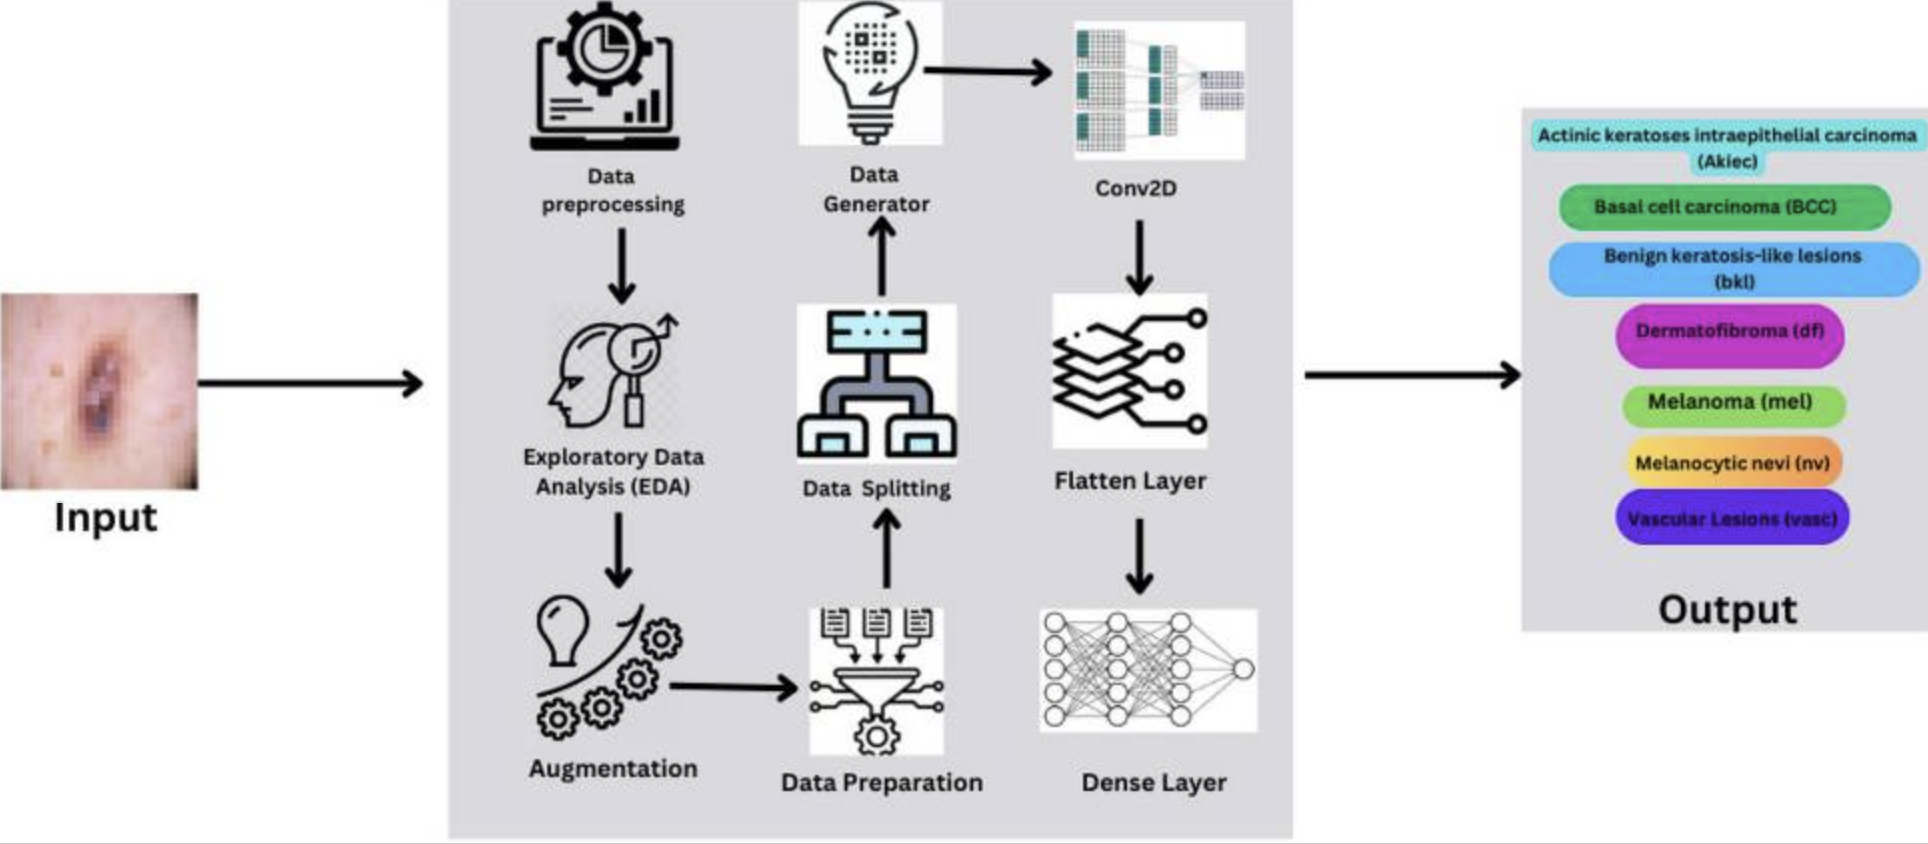 

## EDA
Exploratory Data Analysis (EDA) is a crucial first step in any machine learning project because it helps you understand the structure, quality, and patterns within your dataset before building a model. Through EDA, you can identify class imbalances, missing values, outliers, and inconsistencies, which can significantly affect model performance. It also allows you to visualize distributions, explore relationships between variables, and ensure the data aligns with your assumptions. Overall, EDA provides critical insights that guide data cleaning, preprocessing, and informed model design decisions.
##### DISCLAIMER: code assistance from ChatGPT for EDA processes (graphs)

### Check For Corruptions in the Data/Images

In [35]:
from pathlib import Path
from PIL import Image, UnidentifiedImageError

def find_corrupted_images(root_folder):
    """
    Recursively searches root_folder for .jpg files and returns a list of
    any filenames that Pillow cannot open or verify.
    """
    corrupted = []
    for img_path in Path(root_folder).rglob("*.jpg"):
        try:
            # verify checks the file header; if you want to catch deeper errors,
            # you can follow with img.load()
            with Image.open(img_path) as img:
                img.verify()
        except (UnidentifiedImageError, OSError) as e:
            corrupted.append(img_path)
    return corrupted

if __name__ == "__main__":
    raw_dir = "project/data/raw"   
    bad = find_corrupted_images(raw_dir)
    
    if bad:
        print(f"Found {len(bad)} corrupted images:")
        for p in bad:
            print("  ", p)
    else:
        print("All images opened and verified successfully.")

All images opened and verified successfully.


### Check For Duplicates

In [36]:
import hashlib
from pathlib import Path

def find_duplicate_images(root_folder):
    """
    Walks through root_folder for .jpg files, hashes each file,
    and returns a dict mapping hash -> list of file paths that share it.
    Any hash with >1 path is a set of duplicates.
    """
    hash_map = {}
    for img_path in Path(root_folder).rglob("*.jpg"):
        # Compute MD5 hash of the file bytes
        with open(img_path, "rb") as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        hash_map.setdefault(filehash, []).append(img_path)
    
    # Filter to only those hashes with more than one file
    duplicates = {h: paths for h, paths in hash_map.items() if len(paths) > 1}
    return duplicates

if __name__ == "__main__":
    raw_dir = "project/data/raw"   
    dups = find_duplicate_images(raw_dir)
    
    if dups:
        print(f" Found {sum(len(v) for v in dups.values())} duplicate files in {len(dups)} groups:\n")
        for h, paths in dups.items():
            print(f"Hash: {h}")
            for p in paths:
                print("   ", p)
            print()
    else:
        print("No exact file-duplicates found.")

No exact file-duplicates found.


### Check The Class Imbalance

Image counts by class:
classification
benign       6705
malignant    1113
Name: count, dtype: int64

Percentage of dataset by class:
classification
benign       85.76
malignant    14.24
Name: count, dtype: float64


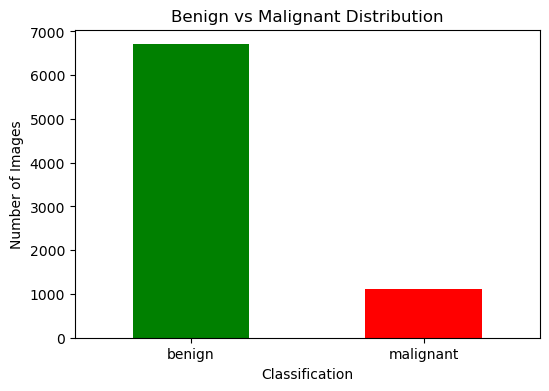

In [7]:
#turn into data frame so can do further EDA
import os
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(data_path)

#counts of each class
counts = df['classification'].value_counts()
print("Image counts by class:")
print(counts)

#percentage of each class
pct = counts / counts.sum() * 100
print("\nPercentage of dataset by class:")
print(pct.round(2))

#bar chart of distribution
colors = ['green' if cls=='benign' else 'red' for cls in counts.index]
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=colors)
plt.title("Benign vs Malignant Distribution")
plt.xlabel("Classification")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()

#### Interpetation of Class Imbalance
There is a significanct imbalance between the benign and malignant classes in this dataset. Malignant is much more rare (14.24%) than benign (85.76%). 
A model trained on this data as-is will tend to predict "benign" more often simply because that’s the majority class. This can inflate overall accuracy while missing malignant cases, which are the clinically critical ones. For this specific scenario, false negatives (malignant predicted as benign) are extremely dangerous, as they can lead to missed cancer diagnoses, delayed treatment, and serious health consequences. Hence, there must be considerations taken in the modelling and evaluation process. To ensure our CNN performs well despite the imbalance, we should adjust the loss function to penalize misclassifications of the minority class more heavily. We can also use data augmentation to increase variation in malignant images (e.g., flips, zooms, rotations) to simulate more examples. We will not attempt to duplicate malignant cases or reduce benign ones as this could risk overfitting or information loss.
This class imbalance also has implications for the metric used to evaluate the models. In this context, standard accuracy is a misleading metric, as a model that always predicts the majority class (benign) could achieve high accuracy while failing to identify malignant cases. This is particularly problematic in a clinical setting where missing a malignant lesion can have serious consequences. Therefore, alternative metrics such as recall, precision, F1-score, and ROC-AUC are more appropriate. Recall for the malignant class is especially critical, as it measures the model's ability to correctly identify true positive cancer cases. 

### Check The Age Distribution

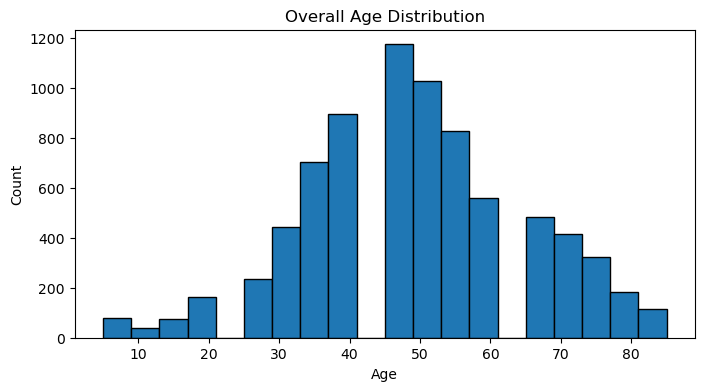

Counts of images by age group and class:
classification  benign  malignant
age_bin                          
0-9                 79          1
10-19              112          0
20-29              379         22
30-39             1078         70
40-49             1948        123
50-59             1614        240
60-69              805        239
70-79              479        257
80-89              136        161 

Proportion of images by age group and class:
classification  benign  malignant
age_bin                          
0-9               0.99       0.01
10-19             1.00       0.00
20-29             0.95       0.05
30-39             0.94       0.06
40-49             0.94       0.06
50-59             0.87       0.13
60-69             0.77       0.23
70-79             0.65       0.35
80-89             0.46       0.54


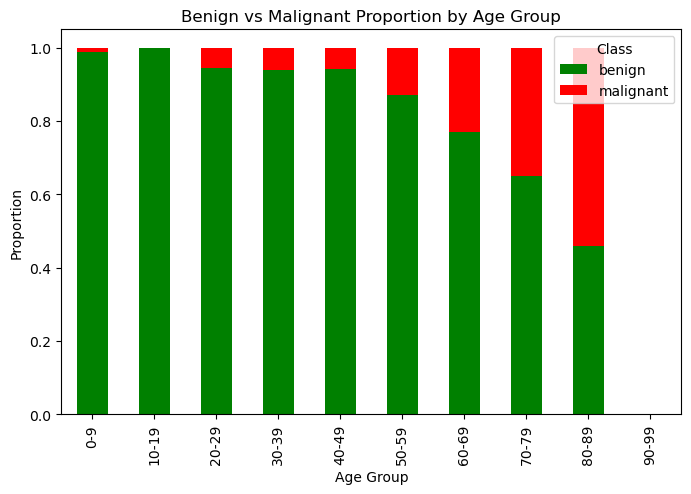

In [8]:
#can check for both the age distribution, and the class distribution across ages.

#age distribution
    #will tell us whether the model can generalize well for all ages, or is better suited for a specific age range
plt.figure(figsize=(8,4))
plt.hist(df['age_approx'].dropna(), bins=20,  edgecolor='black')
plt.title("Overall Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

#class distribution across ages
    #will tell us if certain age groups are more prone to malignancy (will guide clinical interpretations and flag potential biases whereby the model could learn to “cheat” by relying on age-correlated features rather than lesion patterns)
#define age-bins (e.g. decades)
bins   = list(range(0, 101, 10))                      # 0–9,10–19,…,90–99
labels = [f"{b}-{b+9}" for b in bins[:-1]]
df['age_bin'] = pd.cut(df['age_approx'], bins=bins, labels=labels, right=False)

#compute normalized crosstab and reindex to include all bins
prop = pd.crosstab(df['age_bin'], df['classification'], normalize='index') \
         .reindex(labels, fill_value=0)

counts = pd.crosstab(df['age_bin'], df['classification'])
props  = counts.div(counts.sum(axis=1), axis=0)
print("Counts of images by age group and class:")
print(counts, "\n")
print("Proportion of images by age group and class:")
print(props.round(2))

#plot stacked bar with benign=green, malignant=red
prop.plot(kind='bar', stacked=True, figsize=(8,5),
          color=['green','red'])
plt.title("Benign vs Malignant Proportion by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Proportion")
plt.legend(title="Class", loc='upper right')
plt.show()

#### Interpretation of Age Distribution
The dataset is to some degree skewed toward middle-aged and older adults, with the majority of samples coming from individuals aged 30–79, particularly peaking between 40–59 years. Very few samples exist for children and adolescents (under 20), as well as for those aged over 85. This has important consequences, as a model trained on this data is likely to perform best for middle-aged and older adult patients, and its predictions for younger age groups (e.g., 0–19) or very elderly patients (80+) will be less reliable due to limited representation during training. However, this shouldn't become a massive application constraint, as it is unlikely to encounter many patients within these rarer age groups, due to the nature of the disease. 
Another notable consideration is that the proportion of malignant cases increases notably with age, particularly beyond 60, which may influence the underlying distribution of lesion types in the image data. Even though age is not explicitly part of the input, the model may indirectly learn age-related patterns if certain visual traits correlate with patient age. This can limit generalizability, especially when the model is applied to underrepresented groups, such as children or the very elderly.

### Check The Sex Distribution

Counts of images by sex and class:
classification  benign  malignant
sex                              
female            3245        424
male              3423        689 

Proportion of images by sex and class:
classification  benign  malignant
sex                              
female            0.88       0.12
male              0.83       0.17 



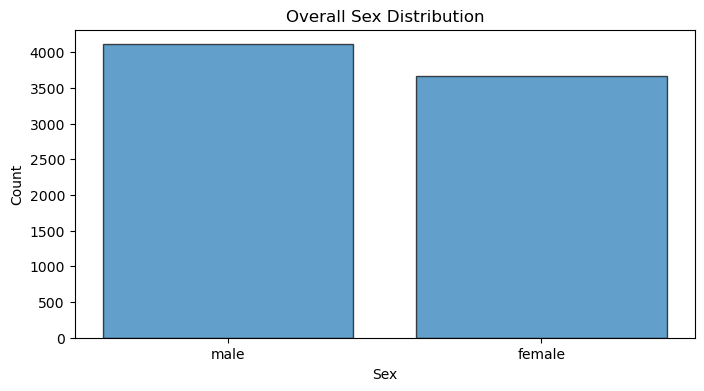

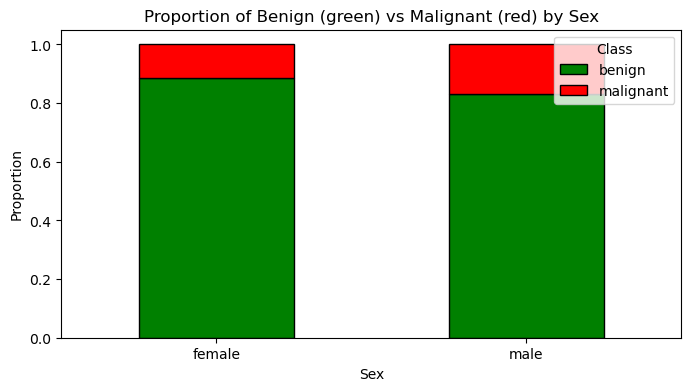

In [9]:
#can check for both the sex distribution, and the class distribution across sex.

#age distribution
    #will tell us whether the model can generalize well for all ages, or is better suited for a specific age range
counts = df['sex'].dropna().value_counts()
plt.figure(figsize=(8,4))
plt.bar(counts.index, counts.values, edgecolor='black', alpha=0.7)
plt.title("Overall Sex Distribution")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.xticks(rotation=0)

#class distribution across ages
    #will tell us if certain age groups are more prone to malignancy (will guide clinical interpretations and flag potential biases whereby the model could learn to “cheat” by relying on age-correlated features rather than lesion patterns)
counts = pd.crosstab(df['sex'], df['classification'])
props  = counts.div(counts.sum(axis=1), axis=0)

print("Counts of images by sex and class:")
print(counts, "\n")
print("Proportion of images by sex and class:")
print(props.round(2), "\n")

plt.figure(figsize=(8,4))
props.plot(
    kind='bar',
    stacked=True,
    color=['green','red'],
    edgecolor='black',
    ax=plt.gca()
)
plt.title("Proportion of Benign (green) vs Malignant (red) by Sex")
plt.xlabel("Sex")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.legend(title="Class", loc='upper right')
plt.show()

#### Interpretation of Sex Distribution
The overall sex distribution in the dataset is relatively balanced, with males making up approximately 54% and females accounting for around 46%. This near parity is beneficial from a modelling perspective, as it helps avoid strong sampling bias toward one group. A balanced distribution means that the image data for both sexes is comparably represented, allowing the model to learn from a diverse set of lesion presentations that are not skewed by sex-based sampling limitations and hence be reliably applied to both males and females in a practical setting. 
Males appear to have a slightly higher proportion of malignant lesions than females, which is knowledge that can be applied in the clinical setting for doctors/practitioners. 

### Check The Anatomical Site Distribution 

Counts of images by anatomical site:
anatom_site_general
lower extremity    1983
posterior torso    1751
NaN                1539
anterior torso     1194
upper extremity     924
head/neck           420
palms/soles           7
Name: count, dtype: int64 



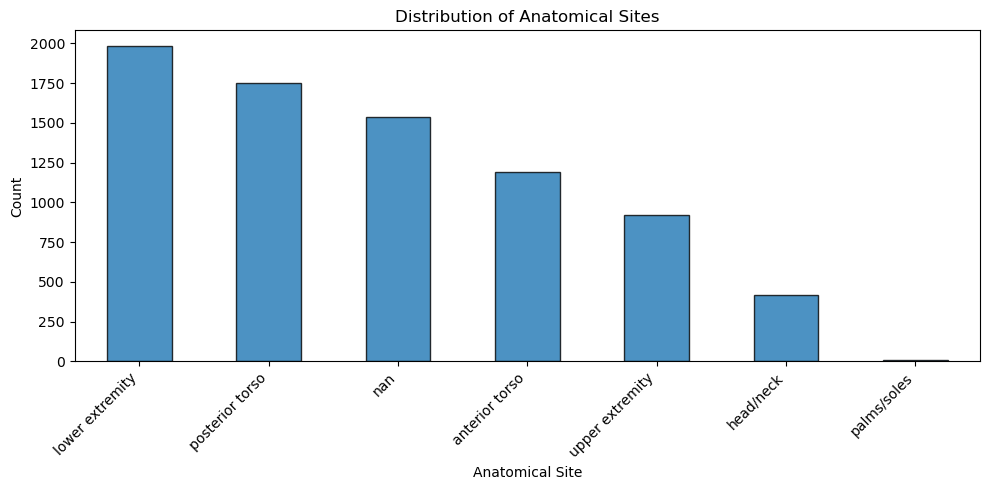

Counts of images by anatomical site and class:
classification       benign  malignant
anatom_site_general                   
anterior torso         1060        134
head/neck               256        164
lower extremity        1763        220
palms/soles               7          0
posterior torso        1427        324
upper extremity         710        214 

Proportion of images by anatomical site and class:
classification       benign  malignant
anatom_site_general                   
anterior torso         0.89       0.11
head/neck              0.61       0.39
lower extremity        0.89       0.11
palms/soles            1.00       0.00
posterior torso        0.81       0.19
upper extremity        0.77       0.23 



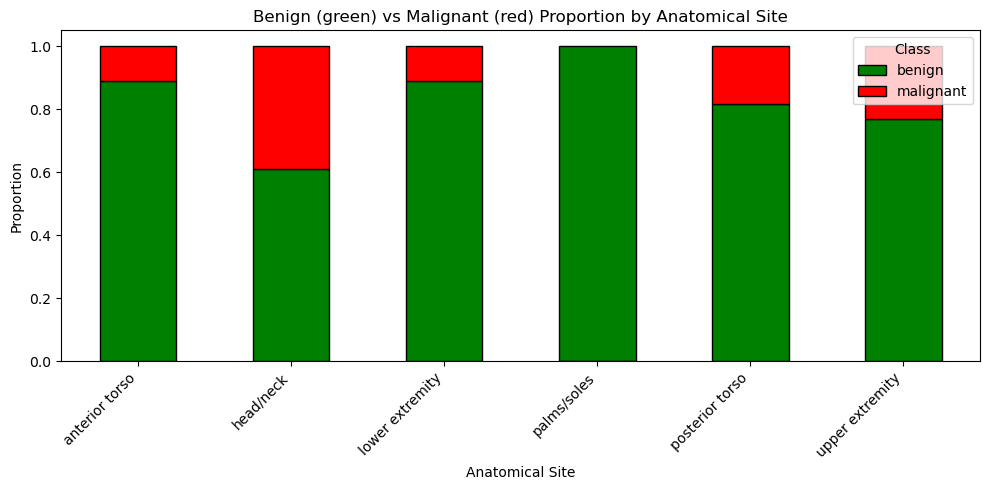

In [10]:
#can check for both the sex distribution, and the class distribution across sex.

#age distribution
    #will tell us whether the model can generalize well for all ages, or is better suited for a specific age range
site_counts = df['anatom_site_general'].value_counts(dropna=False)
print("Counts of images by anatomical site:")
print(site_counts, "\n")

plt.figure(figsize=(10,5))
site_counts.plot(
    kind='bar',
    edgecolor='black',
    alpha=0.8
)
plt.title("Distribution of Anatomical Sites")
plt.xlabel("Anatomical Site")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#class distribution across anatomical sites
site_class_counts = pd.crosstab(df['anatom_site_general'], df['classification'])
print("Counts of images by anatomical site and class:")
print(site_class_counts, "\n")

site_class_props = site_class_counts.div(site_class_counts.sum(axis=1), axis=0)
print("Proportion of images by anatomical site and class:")
print(site_class_props.round(2), "\n")

plt.figure(figsize=(10,5))
site_class_props.plot(
    kind='bar',
    stacked=True,
    color=['green','red'],
    edgecolor='black',
    ax=plt.gca()
)
plt.title("Benign (green) vs Malignant (red) Proportion by Anatomical Site")
plt.xlabel("Anatomical Site")
plt.ylabel("Proportion")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Class", loc='upper right')
plt.tight_layout()
plt.show()

The distribution of lesions across anatomical sites is again imbalanced, with most samples coming from the lower extremity, posterior torso, and anterior torso. Some sites, like palms/soles and head/neck, are underrepresented, and a portion of the data has missing site information (the class called 'nan', which does account for a large portion of observations). Malignancy rates vary significantly by location also, for example, head/neck has a much higher proportion of malignant cases (39%) compared to other areas like the lower extremity (11%). These differences suggest that anatomical site may be a useful predictive feature. However, the imbalance could bias the model toward benign predictions, so class weighting or sampling strategies may be needed. Missing site data should also be handled carefully to avoid introducing noise.

### Other Considerations

It was noticed that there was a mismatch between the number of images in the zip file vs the excel metadata. 
However, it is not required to perform any additional adjustment for this, as the data generator or image loading utility handles it for us automatically.
If any file names listed in the CSV are not found in the directory, the generator simply skips those entries. It only loads images that exist both in the CSV and in the file system, so there's no need to manually remove unmatched rows or check for missing files.

## **FOR SPLITTING:**

In [5]:
orig_folder = core_path + "ISIC Data/ISIC Data/"
prep_folder = core_path + "ISIC Metadata Prepped/"

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import shutil

#we want to do a stratified split rather than a ternary one, as to ensure that the class distribution (i.e., the ratio of benign to malignant cases) is preserved in both the training and testing datasets. 
#this is particularly important because the ISIC dataset is known to be imbalanced, with benign cases significantly outnumbering malignant ones. 
#a stratified split helps maintain representative proportions of each class, allowing the model to learn and be evaluated more reliably. 

def stratified_ternary_split_df(df, ratios, label_col, seed=123):
    """
    Stratified split of df into train/val/test according to ratios.
   
    @param df         : pandas.DataFrame, must contain label_col
    @param ratios     : list or tuple of three floats [r_train, r_val, r_test], summing to 1
    @param label_col  : str, name of the column in df to stratify on
    @param seed       : int, random_state for reproducibility
   
    @return (train_df, val_df, test_df)
    """
    assert len(ratios) == 3, "Provide exactly three ratios"
    assert abs(sum(ratios) - 1.0) < 1e-6, "Ratios must sum to 1"
   
    r_train, r_val, r_test = ratios
   
    # 1) train vs temp
    train_df, temp_df = train_test_split(
        df,
        train_size=r_train,
        random_state=seed,
        stratify=df[label_col]
    )
   
    # 2) val vs test (scale val ratio to the size of temp_df)
    val_ratio_of_temp = r_val / (r_val + r_test)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_ratio_of_temp,
        random_state=seed,
        stratify=temp_df[label_col]
    )
   
    return train_df, val_df, test_df



#A function creating a folder and subfolders to copy data into
def make_subset(df, split, dest_dir, src_dir):
    """
    Create a folder "{name} in the specified directory, adds subfolders ({df.label.unique}), and populates with files (df.filename + ".jpg")

    @param df - DataFrame with filename and label columns 
    @param split - chr, name of the folder to create in the directory (train/val/test)
    @param dest_dir - chr, directory where folders are to be created
    @param src_dir - chr, directory where images currently are

    """
    
    #Extract the unique labels
    labels = df['classification'].unique()
   
    #For each label, create a subfolder and copy files into it
    for label in labels:
        subfolder = os.path.join(dest_dir, split, label)
        os.makedirs(subfolder, exist_ok=True)

        sub_df = df[df['classification'] == label]
        for file_id in sub_df['file_id']:
            fname = f"{file_id}.jpg"
            src_path = os.path.join(src_dir, fname)
            dst_path = os.path.join(subfolder, fname)

            if os.path.exists(src_path):
                shutil.copyfile(src_path, dst_path)
            else:
                print(f"[WARNING] File not found: {src_path}")

In [7]:
file_details = pd.read_csv(core_path + "ISIC Metadata.csv")

In [8]:
file_details['filename'] = file_details['file_id'].astype(str) + '.jpg'

In [9]:
#In this case, let's use a 70/20/10 split. 
    #BOUNDARIES: Less than 60% training would prevent the model from learning complex relationships in the training data, and less than 10% test would not be reliable as a test set given that there are 15 features. 
    #Use as much data as possible for training, but need to ensure a reasonable size for validation and test.
train_files, val_files, test_files = stratified_ternary_split_df(
    file_details,
    ratios=[0.7, 0.2, 0.1],
    label_col='classification',
    seed=123
)

In [10]:
print(file_details.columns)

Index(['file_id', 'classification', 'attribution', 'copyright_license',
       'age_approx', 'anatom_site_general', 'concomitant_biopsy', 'diagnosis',
       'diagnosis_confirm_type', 'image_type', 'lesion_id', 'melanocytic',
       'sex', 'filename'],
      dtype='object')


In [11]:
#Use {split}_files to create each folder and subfolders
make_subset(df = train_files, split = "train", 
            dest_dir = prep_folder, src_dir = orig_folder)
make_subset(df = val_files, split = "val", 
            dest_dir = prep_folder, src_dir = orig_folder)
make_subset(df = test_files, split = "test", 
            dest_dir = prep_folder, src_dir = orig_folder)

### Data Generator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# ————————————————————————————————
#want to make sure core_path and orig_folder are set correctly, as had some issues
core_path = "C:/Users/13973865/OneDrive - Bond University/deep learning/assignment 2/"
orig_folder = core_path + "ISIC Data/ISIC Data/"


#initate the generators (data augmentation / rescaling)
aug_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

#set batch size and target size
batch_size = 32
img_size   = (180, 180)

#build the flows, pointing at orig_folder and using the new filename col
train_ds = aug_gen.flow_from_dataframe(
    dataframe = train_files,
    directory = orig_folder,
    x_col     = 'filename',
    y_col     = 'classification',
    target_size = img_size,
    batch_size  = batch_size,
    shuffle     = True,
    class_mode  = 'categorical'
)

val_ds = val_gen.flow_from_dataframe(
    dataframe = val_files,
    directory = orig_folder,
    x_col     = 'filename',
    y_col     = 'classification',
    target_size = img_size,
    batch_size  = batch_size,
    shuffle     = False,
    class_mode  = 'categorical'
)

test_ds = test_gen.flow_from_dataframe(
    dataframe = test_files,
    directory = orig_folder,
    x_col     = 'filename',
    y_col     = 'classification',
    target_size = img_size,
    batch_size  = batch_size,
    shuffle     = False,
    class_mode  = 'categorical'
)

Found 5472 validated image filenames belonging to 2 classes.
Found 1564 validated image filenames belonging to 2 classes.
Found 782 validated image filenames belonging to 2 classes.


In [13]:
from tensorflow.keras.utils import image_dataset_from_directory

In [14]:
import sys
print(type(train_ds))
print(sys.getsizeof(train_ds)) #48 bytes!

<class 'keras.preprocessing.image.DataFrameIterator'>
48


In [15]:
#confirm that if you loop through, you're pulling out batches
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 2)


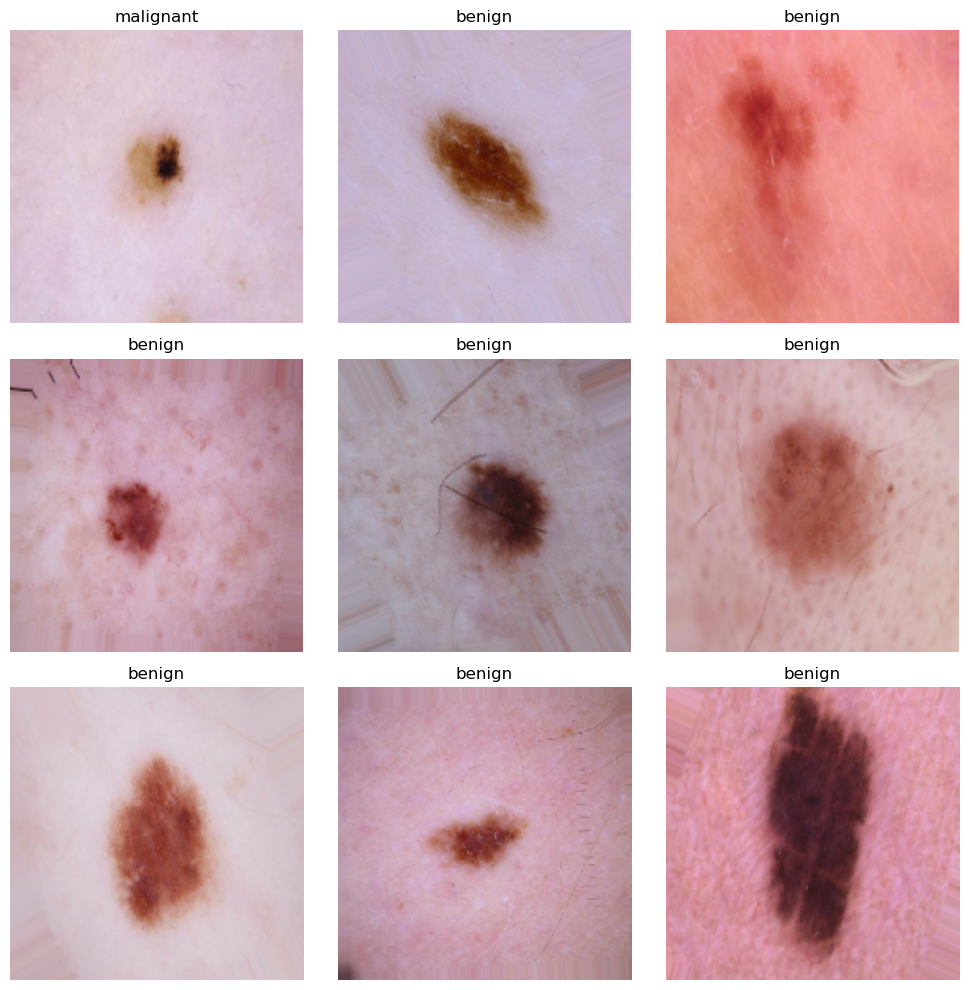

In [16]:
import matplotlib.pyplot as plt

#this code visualizes a sample batch of training images to give a quick visual check of the data being fed into the model. 
#it helps verify that the generator is working as expected and that the images and labels are correctly aligned.

#retrieve one batch of images and corresponding labels from the training dataset.
images_batch, labels_batch = next(train_ds)

#construct a list of class names in the correct index order for later label decoding.
class_names = sorted(train_ds.class_indices, key=lambda x: train_ds.class_indices[x])

#plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    
    # images_batch is already a NumPy array in [0,1]
    plt.imshow(images_batch[i])
    
    # if categorical, labels_batch[i] is one-hot; get the index
    if labels_batch.ndim == 2:
        label_idx = labels_batch[i].argmax()
    else:
        label_idx = int(labels_batch[i])
    plt.title(class_names[label_idx])
    
    plt.axis("off")

plt.tight_layout()
plt.show()

### Utility Function

The utilities section is currently empty because we have moved all utility functions (such as image plotting or metric creation (AUROC) tools) into their own separate section to improve clarity, reusability, and structure in the notebook.

Separating utility functions serves a few key purposes:
* Clean workflow: It avoids cluttering the main training and evaluation code with repetitive helper logic.
* Reusability: Utility functions like plotting or preprocessing helpers can be reused across different experiments or datasets without modification.
* Readability: It makes the notebook easier to follow by clearly separating the tools (utilities) from the workflow (modeling, evaluation, etc.).

#### Metric
Within the helper functions, we defined our metric, which was AUROC. 
AUROC (Area Under the Receiver Operating Characteristic Curve) was chosen over accuracy as the primary evaluation metric because it provides a more reliable measure of model performance on imbalanced datasets, like the skin lesion classification task where benign cases significantly outnumber malignant ones.
Accuracy can be misleading when one class dominates. For example, if 90% of lesions are benign, a model that always predicts "benign" will achieve 90% accuracy, but it will completely fail to detect malignant cases. AUROC, on the other hand, evaluates how well the model distinguishes between the two classes, regardless of class imbalance.
AUROC is also more clinically relevant, as in medical applications, the cost of missing a malignant lesion is much higher than misclassifying a benign one. AUROC reflects the model’s ability to prioritize high-risk (malignant) cases, which is more aligned with clinical goals than overall accuracy.


## Start Building CNN Models
A Convolutional Neural Network (CNN) is a type of deep learning model specifically designed to process data with a grid-like structure, such as images. CNNs automatically learn to extract important features (like edges, shapes, and textures) from input images by applying a series of convolutional layers, activation functions, and pooling layers. These features are then passed through fully connected layers to make predictions (e.g., classifying an image as benign or malignant). CNNs are highly effective for image classification tasks because they can capture spatial hierarchies and patterns in the data without requiring manual feature extraction.

This report will follow a thorough process that leads to development of a final CNN model that aims to classify skin lesions as bengin or malignant. 12 models have been developed through adjusting hyperparameters, adding regularization techniques, and drawing from external case studies, in order to arrive at the final solution. 

### Model 1
This initial CNN model is a simple baseline architecture designed to quickly test whether the core pipeline (data loading, model structure, training loop) works correctly before moving on to more complex models. It takes input images of shape (180, 180, 3) and passes them through two convolutional blocks (conv_block) with increasing filter sizes (16 and 32). The output is flattened and passed to a softmax dense layer with two units, representing the benign and malignant classes.
* The input shape of (180, 180, 3) was chosen as a balance between preserving image detail and keeping the model computationally efficient. 180×180 resolution is large enough to retain important features like lesion shape, border, and color variation, which are crucial for classification, whereas at the same time, it's small enough to reduce training time and memory usage, especially when working with large datasets or limited hardware.
  
This model was chosen as a starting point because it is lightweight, fast to train, and sufficient to establish whether the model can begin learning basic visual patterns. Starting with a smaller model helps identify data or implementation issues early, without requiring long training times or large computational resources. Once validated, the architecture can be expanded for higher performance.

In [17]:
def conv_block(x, K, filters, size, stride, padding, bn_bool):
    """
    Block of K convolutional layers with fixed filters, size, stride, padding, batch normalisation
    maxpooling is aplied after the K convolutional layers
    """

    for _ in range(K):
        x = layers.Conv2D(filters = filters, 
                          use_bias = not bn_bool, #no intercept if normalising
                          kernel_size = size, 
                          strides = stride,
                          padding = padding,
                          activation = None)(x) #add activation after (optional) batch norm
        if bn_bool:
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x) # ReLU chosen to prevent vanishing gradients that plague sigmoid/tanh in deep CNNs
    x = layers.MaxPooling2D(pool_size = (2,2))(x)    

    return x

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
  

# Clear any old graphs / weights
keras.backend.clear_session()

# Now you can use keras.Model(...)
inputs = tf.keras.Input(shape=(180,180,3))

x = conv_block(x=inputs, K=2, filters=16, size=3, stride=1, padding='same', bn_bool=True)
x = conv_block(x=x, K=2, filters=32, size=3, stride=1, padding='same', bn_bool=True)

x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

# Build the model
cvd_mdl = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [26]:
%%time

from tensorflow.keras.optimizers  import Adam
from tensorflow.keras.losses      import CategoricalCrossentropy
from tensorflow.keras.metrics     import AUC

# Compile the model
cvd_mdl.compile(optimizer=Adam(learning_rate = 0.001), #use this learning rate as a starting point, as generally pretty stable but not too slow
              loss=CategoricalCrossentropy(), #not BinaryCrossentropy as our model uses a two-unit softmax with one-hot labels, and so we need CategoricalCrossentropy. BinaryCrossentropy is only appropriate for a single-unit sigmoid output with scalar labels.
              metrics = [AUC(name='auroc', curve='ROC')] )

#Fit the model
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10, #As a starting point (will run quicker and allow us to see what is happening sooner)
    verbose = 1) 

Epoch 1/10
30/43 [===================>..........] - ETA: 1:30 - loss: 3.9755 - auroc: 0.8376

KeyboardInterrupt: 

In [27]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)             # create folders if needed
history_path = os.path.join(history_dir, 'm1_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

KeyError: 'loss'

Comments
* very unstable (plot changes dramatically every time)
* the large oscillations suggest early layers receive tiny updates, a likely vanishing-gradient effect in this plain CNN.
* doesn't raise an issue of not being enough epochs (don't expected to see a much different trend if keep going) (no apparent need to change epochs so far)
* this model has an explosion in parameters at the dense layer when the convolutional outputs are flattened. When we flatten the last conv‐block output and then immediately connect it to a single dense layer, we force that one layer to learn a weight for every activation coming out of the convs, causing that one dense layer to bear the entire parameter burden.

Plan of Action:
* Reduce the parameter count while also increasing the depth of the network. We’ll add a third convolutional block so that instead of flattening a 45×45×32 feature map (45 × 45 × 32 = 64 800 elements), we flatten a down‐sampled 22×22×64 feature map (22 × 22 × 64 = 30 976 elements).

### Model 2

In [27]:
keras.backend.clear_session()

inputs = tf.keras.Input(shape=(180,180,3))
x = conv_block(x=inputs, K=2, filters=16, size=3, stride=1, padding='same', bn_bool=True)
x = conv_block(x=x, K=2, filters=32, size=3, stride=1, padding='same', bn_bool=True)
x = conv_block(x=x, K=2, filters=64, size=3, stride=1, padding='same', bn_bool=True) #add another convolutional layer
    #it is common to increase nodes in a funnel shape within a CNN, because deeper layers need even more filters to represent the higher-level motifs and object parts that the network is detecting. The method generally followed is the x2 rule.

x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

# Build the model
cvd_mdl = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl.summary()
    #61,954 is a significant improvement in the number of parameters, compared to 129,602. 60k generally works well for most tasks and datasets of moderate size. Hence, we will only need to reduce it further if we still hit overfitting or training instability, which will be seen in the plot.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [28]:
%%time

# Compile the model
cvd_mdl.compile(optimizer=Adam(learning_rate = 0.001),
              loss=CategoricalCrossentropy(), 
              metrics = [AUC(name='auroc', curve='ROC')] )

#Fit the model
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10, #no apparent need to change this so far
    verbose = 1) 

Epoch 1/10
43/43 [==============================] - 58s 1s/step - loss: 1.0165 - auroc: 0.8907 - val_loss: 0.3625 - val_auroc: 0.9298
Epoch 2/10
43/43 [==============================] - 38s 883ms/step - loss: 0.3187 - auroc: 0.9380 - val_loss: 0.6271 - val_auroc: 0.8136
Epoch 3/10
43/43 [==============================] - 28s 643ms/step - loss: 0.3213 - auroc: 0.9373 - val_loss: 0.5505 - val_auroc: 0.9233
Epoch 4/10
43/43 [==============================] - 28s 642ms/step - loss: 0.3150 - auroc: 0.9419 - val_loss: 0.4984 - val_auroc: 0.8915
Epoch 5/10
43/43 [==============================] - 28s 641ms/step - loss: 0.3060 - auroc: 0.9459 - val_loss: 0.3745 - val_auroc: 0.9133
Epoch 6/10
43/43 [==============================] - 28s 640ms/step - loss: 0.3642 - auroc: 0.9392 - val_loss: 0.3982 - val_auroc: 0.8872
Epoch 7/10
43/43 [==============================] - 28s 638ms/step - loss: 0.3278 - auroc: 0.9470 - val_loss: 0.7008 - val_auroc: 0.6026
Epoch 8/10
43/43 [==========================

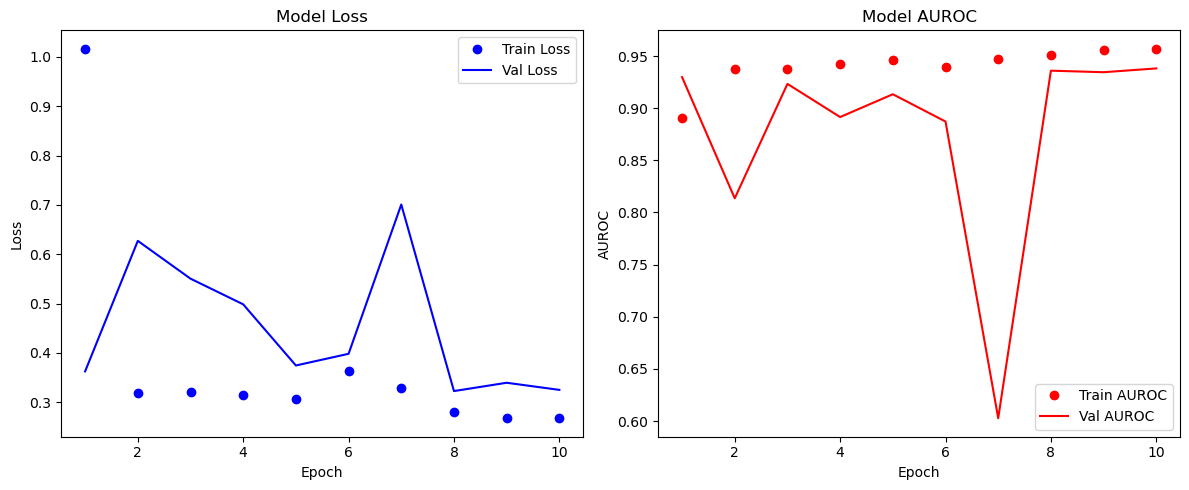

Maximum Validation AUROC = 0.9381 after epoch 10


In [29]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)             
history_path = os.path.join(history_dir, 'm2_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

Comments:
* validation AUROC looks much more stable and slightly higher overall
* upper range of loss plot has reduced significantly (no longer starts with loss at 2-3, but now is 1).
* max AUROC occurs after epoch 10, which now suggest a need for slightly more epochs, as both the loss and AUROC plots look as though they could continue to improve. 

Suggests:
* adding a third conv layer gave the model more hierarchical feature learning capacity, so it fits the data better and generalizes more reliably.

Plan of action:
* test this model for another 10 epochs

In [30]:
%%time
#train for another 10 epochs
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10, 
    verbose = 1)

Epoch 1/10
43/43 [==============================] - 28s 641ms/step - loss: 0.2695 - auroc: 0.9571 - val_loss: 0.3000 - val_auroc: 0.9504
Epoch 2/10
43/43 [==============================] - 28s 639ms/step - loss: 0.2606 - auroc: 0.9593 - val_loss: 0.2673 - val_auroc: 0.9555
Epoch 3/10
43/43 [==============================] - 36s 848ms/step - loss: 0.2569 - auroc: 0.9600 - val_loss: 0.3006 - val_auroc: 0.9444
Epoch 4/10
43/43 [==============================] - 48s 1s/step - loss: 0.2571 - auroc: 0.9602 - val_loss: 0.3039 - val_auroc: 0.9477
Epoch 5/10
43/43 [==============================] - 28s 644ms/step - loss: 0.2522 - auroc: 0.9609 - val_loss: 0.3675 - val_auroc: 0.9266
Epoch 6/10
43/43 [==============================] - 28s 645ms/step - loss: 0.2534 - auroc: 0.9611 - val_loss: 0.3668 - val_auroc: 0.9203
Epoch 7/10
43/43 [==============================] - 28s 642ms/step - loss: 0.2328 - auroc: 0.9670 - val_loss: 0.2974 - val_auroc: 0.9481
Epoch 8/10
43/43 [==========================

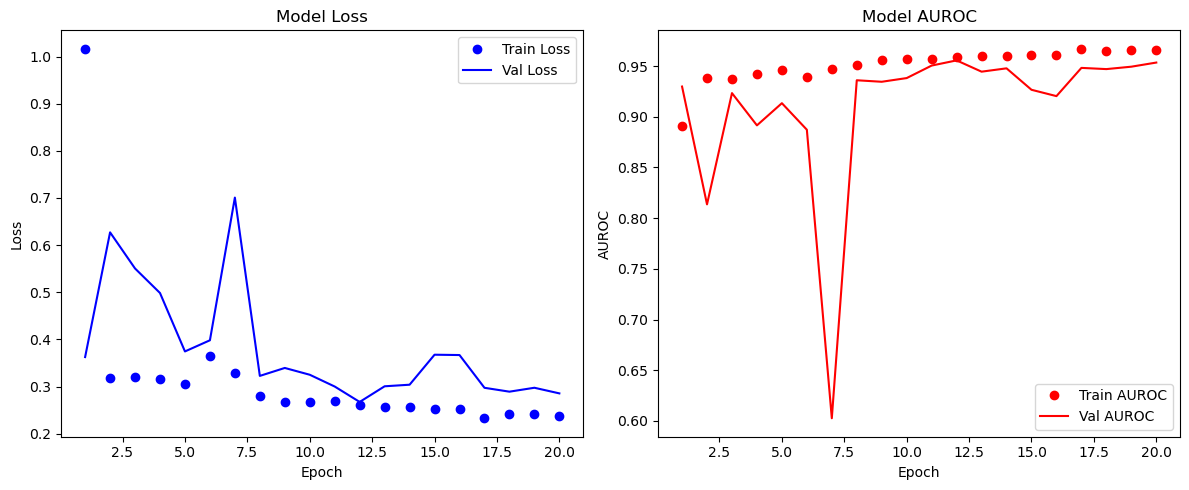

Maximum Validation AUROC = 0.9555 after epoch 12


In [31]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm2.2_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = combine_histories(mdl_hstry, cvd_mdl.history.history)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

Comments:
* doing an additional 10 epochs was probably excessive.
* performance visually appears to continue to improve, however max AUROC occurs after epoch 12. we can infer then that after 12 epochs performance then more-or-less plateaus.
* after 12 epochs the performance gap between validation and train begins to widen, only sightly, suggesting we've hit diminishing returns (and a touch of overfitting).

Suggest:
* the increased depth and reduced size of the fully connected layer has clearly improved things. Performance is much more stable, it now takes 12 epochs before validation performance levels off, and it levels off at a higher level of accuracy. After 12 epochs however, we begin to run into the old problem of only the noise being learned, and not generalisable features, leading to plateu.
  
Plan of Action: 
* we could regularise or tune the existing components of the model, but we have a prior expectation (from case studies) that depth is important, and it seems like it would be more beneficial if increased depth actually decreases the total parameter count due to reductions in the size of the final hidden layer.
* we will hence add another convolution block, however if we increase the number of filters again (following the x2 fule; from 64 - 128), we will run back into the issue of an explosion in parameter count. As such, we will add another convolutional block, but keep the filter count at 64. As seen in the case studies with VGG and ResNet, they also utilised this general idea, and we can be confident that using a much lower size of filter will be suitable for us, due to a much simplier classifier issue (two class (binary), not 1000 like in ImageNet) (this is an asusmption, and whether it is reasonable or not will be seen by the results). 
* due to not changing the filter size, we won't be able to reduce our parameter count (instead it will stay more or less constant).  

### Model 3

In [32]:
keras.backend.clear_session()

inputs = tf.keras.Input(shape=(180,180,3))
x = conv_block(x=inputs, K=2, filters=16, size=3, stride=1, padding='same', bn_bool=True)
x = conv_block(x=x, K=2, filters=32, size=3, stride=1, padding='same', bn_bool=True)
x = conv_block(x=x, K=2, filters=64, size=3, stride=1, padding='same', bn_bool=True)
x = conv_block(x=x, K=2, filters=64, size=3, stride=1, padding='same', bn_bool=True) #add another convolutional layer
    #it is common to increase nodes in a funnel shape within a CNN, because deeper layers need even more filters to represent the higher-level motifs and object parts that the network is detecting. The method generally followed is the x2 rule.

x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

# Build the model
cvd_mdl = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl.summary()
    #the last dense layer is only 15,490 now, the last two convolutional layers are the biggest. 
    #we've shifted most capacity into extra convolutional depth (good for richer feature hierarchies) while still keeping the head lightweight.
    #the moderate overall growth in parameters shows we’re avoiding the “explode‐and‐explode” trap we would have encountered had we doubled to 128 filters.
    #the final Dense(2) head is just 15,490 parameters, only about 9.5% of the total, so we have successfully pushed capacity into convolutional features rather than the classifier.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [33]:
%%time

# Compile the model
cvd_mdl.compile(optimizer=Adam(learning_rate = 0.001),
              loss=CategoricalCrossentropy(), 
              metrics = [AUC(name='auroc', curve='ROC')] )

#Fit the model
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 15, #we have decided to increase to 15 epochs, based on what we previously saw in the performance patterns. 
    verbose = 1)

Epoch 1/15
43/43 [==============================] - 57s 1s/step - loss: 0.5707 - auroc: 0.8986 - val_loss: 0.4609 - val_auroc: 0.9118
Epoch 2/15
43/43 [==============================] - 28s 643ms/step - loss: 0.3243 - auroc: 0.9327 - val_loss: 0.5438 - val_auroc: 0.9228
Epoch 3/15
43/43 [==============================] - 28s 643ms/step - loss: 0.3123 - auroc: 0.9383 - val_loss: 0.4305 - val_auroc: 0.9076
Epoch 4/15
43/43 [==============================] - 28s 638ms/step - loss: 0.2909 - auroc: 0.9464 - val_loss: 0.3890 - val_auroc: 0.9044
Epoch 5/15
43/43 [==============================] - 28s 638ms/step - loss: 0.2849 - auroc: 0.9483 - val_loss: 0.3731 - val_auroc: 0.9170
Epoch 6/15
43/43 [==============================] - 28s 641ms/step - loss: 0.2734 - auroc: 0.9531 - val_loss: 0.4737 - val_auroc: 0.8972
Epoch 7/15
43/43 [==============================] - 28s 641ms/step - loss: 0.2683 - auroc: 0.9552 - val_loss: 0.4477 - val_auroc: 0.9415
Epoch 8/15
43/43 [==========================

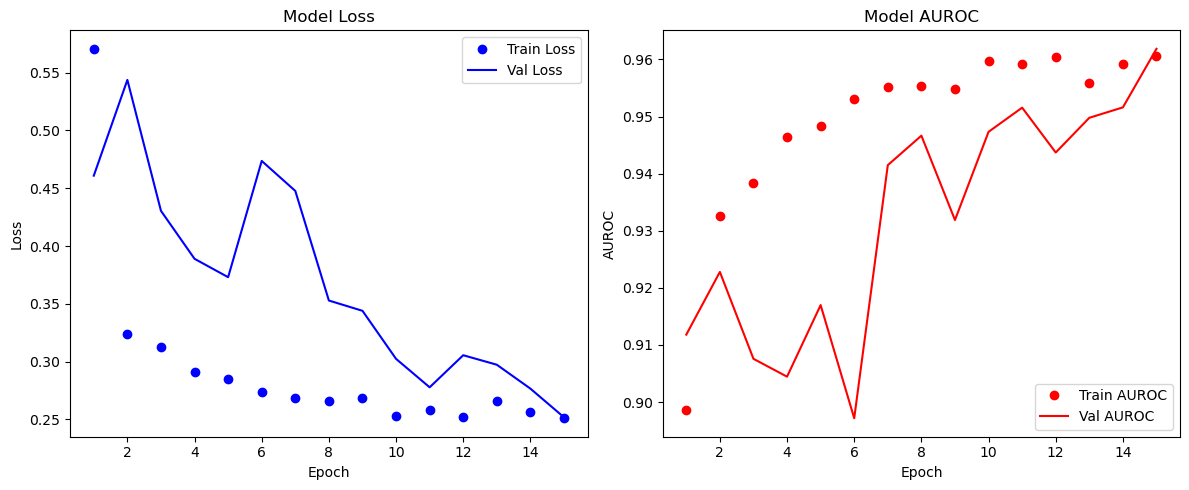

Maximum Validation AUROC = 0.9619 after epoch 15


In [34]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm3_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

Comments:
* this looks good. Visually it appears like performance is lower and more unstable, but consider the y-range of the graphs, and we can see that performance is actually very high and stable.
* validation looks like it could be continuing to improve on both the loss and AUROC plots, so we should run for another 10 epochs. (this may be too many as we are already at quite high performance (0.9619 AUROC), however the upwards trend of the val AUROC and the downwards trend of the val loss look very strong).
* overall, performance has been nudged up from 95.55% to 96.19%

Suggests:
* this shows that the additional conv layers mean the deeper network is more powerful.
* batch normalisation in model 2 and 3 keeps activations numerically well-behaved, mitigating the vanishing-gradient issue we saw in Model 1.

Plan of Action:
* run for another 10 epochs

In [35]:
%%time
#train for another 10 epochs
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10, 
    verbose = 1)

Epoch 1/10
43/43 [==============================] - 54s 1s/step - loss: 0.2410 - auroc: 0.9641 - val_loss: 0.2899 - val_auroc: 0.9492
Epoch 2/10
43/43 [==============================] - 28s 634ms/step - loss: 0.2462 - auroc: 0.9625 - val_loss: 0.2485 - val_auroc: 0.9617
Epoch 3/10
43/43 [==============================] - 28s 639ms/step - loss: 0.2441 - auroc: 0.9631 - val_loss: 0.3593 - val_auroc: 0.9166
Epoch 4/10
43/43 [==============================] - 28s 637ms/step - loss: 0.2371 - auroc: 0.9651 - val_loss: 0.3372 - val_auroc: 0.9348
Epoch 5/10
43/43 [==============================] - 28s 635ms/step - loss: 0.2353 - auroc: 0.9655 - val_loss: 0.3034 - val_auroc: 0.9568
Epoch 6/10
43/43 [==============================] - 28s 637ms/step - loss: 0.2343 - auroc: 0.9658 - val_loss: 0.3852 - val_auroc: 0.9153
Epoch 7/10
43/43 [==============================] - 28s 637ms/step - loss: 0.2332 - auroc: 0.9663 - val_loss: 0.3134 - val_auroc: 0.9379
Epoch 8/10
43/43 [==========================

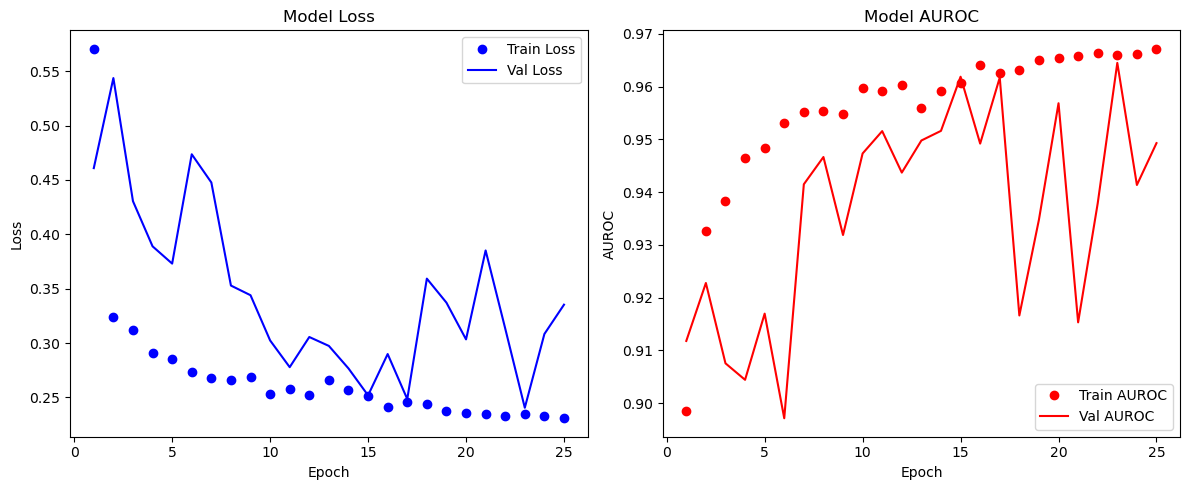

Maximum Validation AUROC = 0.9645 after epoch 23


In [36]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm3.2_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = combine_histories(mdl_hstry, cvd_mdl.history.history)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

Comments:
* the AUROC did increase slightly, peaking at the 23rd epoch (96.45%), showing that the fourth conv‐block is still squeezing out a bit more discriminative power.
* After about epoch 17 the gains in val AUROC slow to a crawl, and you still see jagged spikes in both val loss (notably around epochs 18, 21, and 25) and val AUROC (dips at the same points). Meanwhile train AUROC keeps inching upwards toward approx. 0.97 and train loss steadily decreases.

Suggests:
* this shows we are now in the “long tail” of improvement, whereby each extra epoch yields ever smaller boosts in generalization, and the model’s still a bit unstable on the hold-out set.
* the narrowing train–val gap (around epoch 12-17) suggests we’ve largely tamed over-fitting with depth alone, but those occasional spikes that become more severe in the later epochs hint that a regularization technique is needed.

Plan of Action:
* if we continue to increase model depth (add layers), the parameter count will continue to grow, and hence we want to avoid this.
* the most obvious way of reducing the overfitting of the training data without reducing capacity is to introduce regularisation. Dropout is great, but doesn't work well for convolutional layers, which are the bulk of our network. We will instead pursue "weight decay" (L2 regularisation), as that form of regularisation has been successful in some of the big networks we saw as case studies.
* When implementing regularisation, we want a penalty that isn't so small as to be meaningless, and isn't so large that it forces the network to underfit. Let's start with a really small penalty (the one used in AlexNet and VGG-19) and we can slowly increase it to find the sweet spot. To implement L2 regularisation with our "block" approach, we'll update the conv_block function

### Model 4

In [18]:
def conv_block_l2(x, K, filters, size, stride, padding, l2_wgt, bn_bool):
    """
    Block of K convolutional layers with fixed filters, size, stride, padding, l2 reg, batch norm
    maxpooling is aplied after the K convolutional layers
    """

    for _ in range(K):
        x = layers.Conv2D(filters=filters, 
                          use_bias = not bn_bool, #no intercept if normalising
                          kernel_size = size, 
                          strides = stride,
                          padding=padding,
                          kernel_regularizer = l2(l2_wgt),
                          activation = None)(x) #add activation after (optional) batch norm
        if bn_bool:
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x) # ReLU chosen to prevent vanishing gradients that plague sigmoid/tanh in deep CNNs
    x = layers.MaxPooling2D(pool_size = (2,2))(x)    

    return x

In [40]:
keras.backend.clear_session()

inputs = tf.keras.Input(shape = (180,180,3)) 
x = conv_block_l2(x=inputs, K=2, filters=16, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=32, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)

x = layers.Flatten()(x)
outputs = layers.Dense(2, kernel_regularizer = l2(0.0005), activation = 'softmax')(x)

cvd_mdl = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl.summary() 
    #parameter counts didn’t change with L2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [42]:
%%time
# Compile the model
cvd_mdl.compile(optimizer=Adam(learning_rate = 0.001),
              loss=CategoricalCrossentropy(), 
                metrics = [AUC(name='auroc', curve='ROC')] )

#Fit the model
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 40, #adding L2 weight decay mean our model will tend to learn more slowly (since every weight update is also pulling weights toward zero). this means we may need a few extra epochs (e.g. 30–40) to reach the same training loss/AUROC we saw without regularization. 
    verbose = 1)

Epoch 1/40
43/43 [==============================] - 28s 646ms/step - loss: 0.6957 - auroc: 0.9036 - val_loss: 0.5272 - val_auroc: 0.9148
Epoch 2/40
43/43 [==============================] - 28s 640ms/step - loss: 0.4694 - auroc: 0.9393 - val_loss: 0.5242 - val_auroc: 0.9202
Epoch 3/40
43/43 [==============================] - 28s 648ms/step - loss: 0.4566 - auroc: 0.9438 - val_loss: 0.5436 - val_auroc: 0.9249
Epoch 4/40
43/43 [==============================] - 28s 641ms/step - loss: 0.4413 - auroc: 0.9469 - val_loss: 0.6386 - val_auroc: 0.9153
Epoch 5/40
43/43 [==============================] - 28s 643ms/step - loss: 0.4231 - auroc: 0.9528 - val_loss: 0.5867 - val_auroc: 0.9250
Epoch 6/40
43/43 [==============================] - 36s 838ms/step - loss: 0.4183 - auroc: 0.9534 - val_loss: 0.5270 - val_auroc: 0.9343
Epoch 7/40
43/43 [==============================] - 47s 1s/step - loss: 0.4126 - auroc: 0.9544 - val_loss: 0.5955 - val_auroc: 0.9314
Epoch 8/40
43/43 [==========================

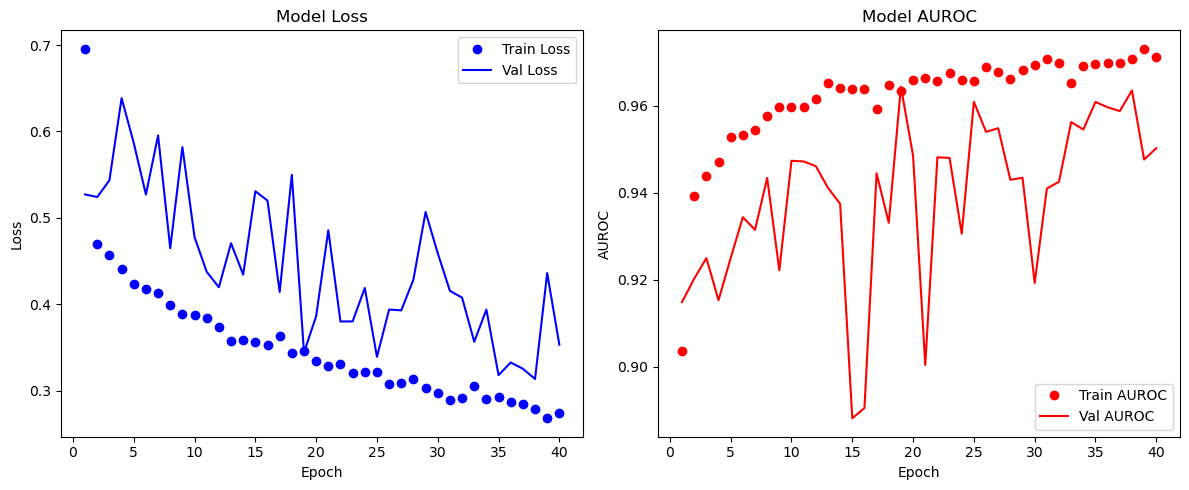

Maximum Validation AUROC = 0.9643 after epoch 19


In [43]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm4_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

Comments:
* slower but steadier training: the train loss now declines more gradually over 40 epochs, reflecting the weight‐decay penalty pulling weights toward zero at each step. train AUROC still climbs toward ~0.97, but it takes longer to get there than in the unregularized runs.
* performance of the model is actually not as good, as the maximum AUROC has decreased (to a very minor degree - may change if run again, but definetly does not show a significant improvement).
* validation remains noisy and unstable (consider the y-range is again small, so if zoom out would see much smoother performance, but none-the-less).

Suggests:
* L2 helped generalization slightly by smoothing weight magnitudes, but it didn’t fully tame the volatility in validation performance.
* we are now in the regime of diminishing returns AGAIN, where extra epochs and weight decay alone aren’t pushing the ceiling much higher (maxes out after epoch 19), and the remaining noise suggests we need an additional form of regularization.

Plan of Action:
* we want to try a new L2 penalty/weight
* we will try INCREASING the penalty by doubling it to 0.001. This will mean any weight growth is penalized more harshly. This forces the network’s filters to stay smaller and smoother, which can help tamp down the remaining validation‐loss spikes and overfitting we’ve been seeing. We are essentially testing whether a heavier “shrink” on the weights leads to better generalization. 

### Model 5

In [45]:
keras.backend.clear_session()

inputs = tf.keras.Input(shape = (180,180,3)) 
x = conv_block_l2(x=inputs, K=2, filters=16, size=3, stride=1, padding='same',l2_wgt=0.001, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=32, size=3, stride=1, padding='same',l2_wgt=0.001, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.001, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.001, bn_bool=True)

x = layers.Flatten()(x)
outputs = layers.Dense(2, kernel_regularizer = l2(0.001), activation = 'softmax')(x)

cvd_mdl = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [46]:
%%time
# Compile the model
cvd_mdl.compile(optimizer=Adam(learning_rate = 0.001),
              loss=CategoricalCrossentropy(), 
                metrics = [AUC(name='auroc', curve='ROC')] )

#Fit the model
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 40, 
    verbose = 1)

Epoch 1/40
43/43 [==============================] - 28s 643ms/step - loss: 0.9403 - auroc: 0.8983 - val_loss: 0.7626 - val_auroc: 0.8750
Epoch 2/40
43/43 [==============================] - 28s 639ms/step - loss: 0.6201 - auroc: 0.9400 - val_loss: 0.8235 - val_auroc: 0.9141
Epoch 3/40
43/43 [==============================] - 28s 640ms/step - loss: 0.5939 - auroc: 0.9466 - val_loss: 0.9298 - val_auroc: 0.9100
Epoch 4/40
43/43 [==============================] - 28s 641ms/step - loss: 0.5734 - auroc: 0.9503 - val_loss: 0.7660 - val_auroc: 0.9234
Epoch 5/40
43/43 [==============================] - 28s 641ms/step - loss: 0.5538 - auroc: 0.9537 - val_loss: 0.6280 - val_auroc: 0.9346
Epoch 6/40
43/43 [==============================] - 28s 637ms/step - loss: 0.5396 - auroc: 0.9549 - val_loss: 0.7191 - val_auroc: 0.9186
Epoch 7/40
43/43 [==============================] - 28s 640ms/step - loss: 0.5189 - auroc: 0.9582 - val_loss: 0.8085 - val_auroc: 0.9327
Epoch 8/40
43/43 [=======================

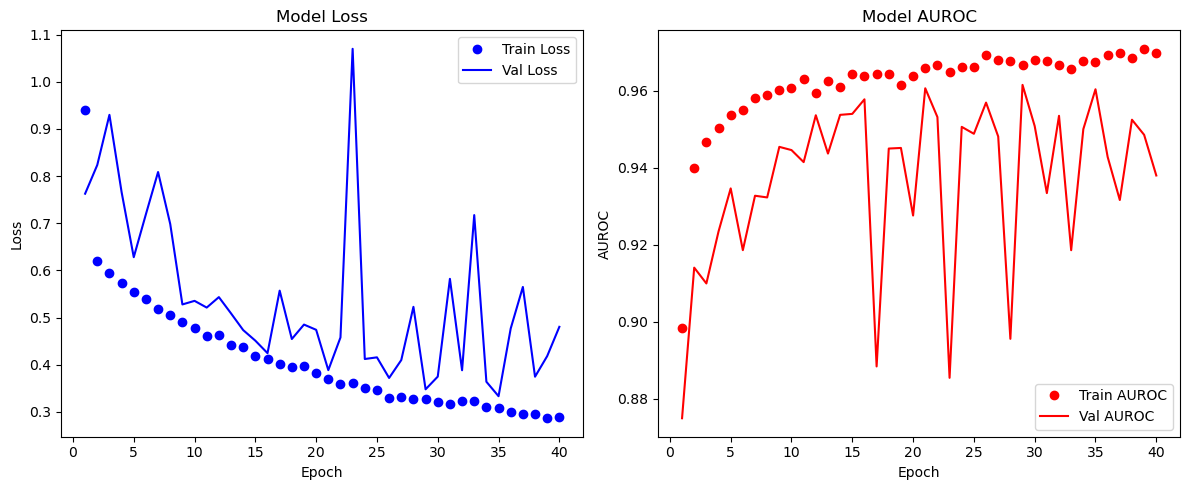

Maximum Validation AUROC = 0.9615 after epoch 29


In [47]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm5_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

Comments:
* with an L2 penalty of 0.001, we see slower convergence (the train loss is dropping more gently, but still reaches ~0.29 by epoch 40 (vs. ~0.26 previously).
* the spikes have not been smoothed/tamed (the massive val‐loss spikes (e.g. around epoch 24) are just as wild, if not wilder)
* the peak generalization is actually slightly worse (max val AUROC is 0.9615 (epoch 29), down from what we got with 0.0005).

Suggests:
* doubling the penalty has hurt rather than helped the model, as it is now underfitting a bit and still highly unstable on the hold-out (validation) set.

Plan of Action:
* lets drop back to the lighter penalty
* we will try a penalty half of what we started with (0.00025, half of 0.0005), to see if moving in the OPPOSITE direction (decreasing penalty) helps. 

### Model 6

In [48]:
keras.backend.clear_session()

inputs = tf.keras.Input(shape = (180,180,3)) 
x = conv_block_l2(x=inputs, K=2, filters=16, size=3, stride=1, padding='same',l2_wgt=0.00025, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=32, size=3, stride=1, padding='same',l2_wgt=0.00025, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.00025, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.00025, bn_bool=True)

x = layers.Flatten()(x)
outputs = layers.Dense(2, kernel_regularizer = l2(0.00025), activation = 'softmax')(x)

cvd_mdl = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [50]:
%%time
# Compile the model
cvd_mdl.compile(optimizer=Adam(learning_rate = 0.001),
              loss=CategoricalCrossentropy(), 
                metrics = [AUC(name='auroc', curve='ROC')] )

#Fit the model
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 40, 
    verbose = 1)

Epoch 1/40
43/43 [==============================] - 53s 1s/step - loss: 0.4473 - auroc: 0.9226 - val_loss: 0.6462 - val_auroc: 0.9124
Epoch 2/40
43/43 [==============================] - 28s 646ms/step - loss: 0.3866 - auroc: 0.9425 - val_loss: 0.4569 - val_auroc: 0.9218
Epoch 3/40
43/43 [==============================] - 28s 638ms/step - loss: 0.3826 - auroc: 0.9446 - val_loss: 0.4325 - val_auroc: 0.9303
Epoch 4/40
43/43 [==============================] - 28s 640ms/step - loss: 0.3535 - auroc: 0.9511 - val_loss: 0.6406 - val_auroc: 0.9289
Epoch 5/40
43/43 [==============================] - 27s 634ms/step - loss: 0.3442 - auroc: 0.9545 - val_loss: 0.4296 - val_auroc: 0.9457
Epoch 6/40
43/43 [==============================] - 28s 638ms/step - loss: 0.3373 - auroc: 0.9554 - val_loss: 0.4304 - val_auroc: 0.9403
Epoch 7/40
43/43 [==============================] - 28s 636ms/step - loss: 0.3312 - auroc: 0.9581 - val_loss: 0.4735 - val_auroc: 0.9223
Epoch 8/40
43/43 [==========================

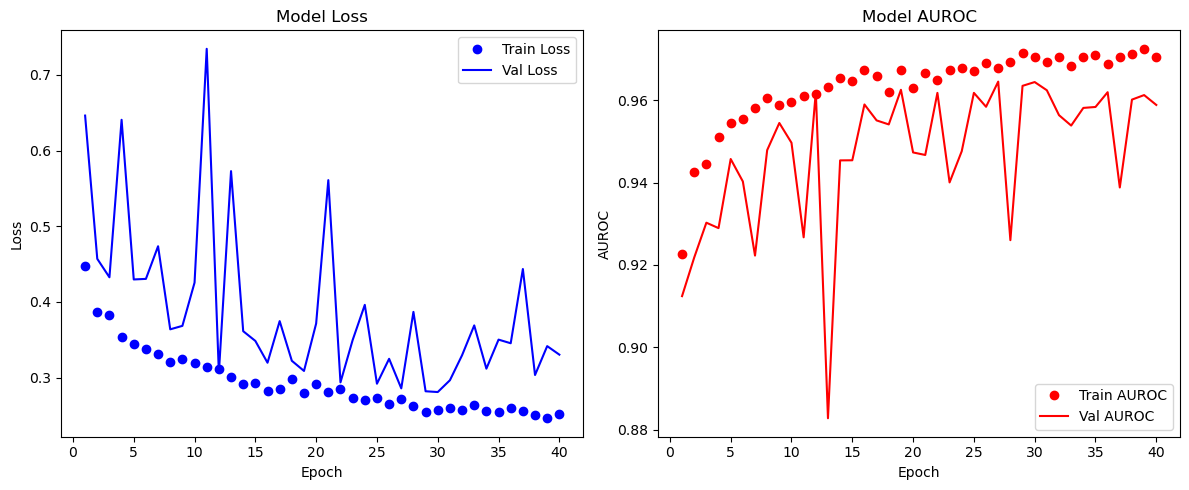

Maximum Validation AUROC = 0.9645 after epoch 27


In [51]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm6_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

*L2 Penalty*

Comments:
* there is not any significant difference between this model and the model trained on the 0.0005 penalty.
* the performance is very much the same, and the max AUROC is only 0.0002 higher.
* the lower penalty model (this one) has the max AUROC peak occuring later (at 27 epochs, vs 19 epochs), meaning it takes slightly longer to get there.
* hence, we should stick with 0.0005 penalty so we can iterate faster and still hit the same generalization ceiling.

Plan of Action:
* keep the 0.0005 L2 penalty


*Learning Rate*

Comments:
* the validation curves are still very wild.

Plan of Action: 
* decreasing learning rate lets the model moves more cautiously and steadily down the loss landscape, smoothing out the jagged validation spikes we've been seeing.
* it will also improve convergence in late training. we are now in the long tail of performance gains, where big steps can make you jump past the small, narrow minima that yield better generalization. A lower LR helps you inch toward those finer improvements rather than overshoot them.
* we will halve the learning rate, as to not jump too much. (0.001 -> 0.0005)

### Model 7

In [52]:
keras.backend.clear_session()

inputs = tf.keras.Input(shape = (180,180,3)) 
x = conv_block_l2(x=inputs, K=2, filters=16, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=32, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)

x = layers.Flatten()(x)
outputs = layers.Dense(2, kernel_regularizer = l2(0.0005), activation = 'softmax')(x)

cvd_mdl = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [53]:
%%time
# Compile the model
cvd_mdl.compile(optimizer=Adam(learning_rate = 0.0005),
              loss=CategoricalCrossentropy(), 
                metrics = [AUC(name='auroc', curve='ROC')] )

#Fit the model
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 40, 
    verbose = 1)

Epoch 1/40
43/43 [==============================] - 55s 1s/step - loss: 0.7002 - auroc: 0.8951 - val_loss: 0.5527 - val_auroc: 0.9149
Epoch 2/40
43/43 [==============================] - 27s 633ms/step - loss: 0.4484 - auroc: 0.9467 - val_loss: 0.5621 - val_auroc: 0.9110
Epoch 3/40
43/43 [==============================] - 28s 641ms/step - loss: 0.4285 - auroc: 0.9538 - val_loss: 0.6420 - val_auroc: 0.9068
Epoch 4/40
43/43 [==============================] - 28s 637ms/step - loss: 0.4264 - auroc: 0.9539 - val_loss: 0.6850 - val_auroc: 0.9072
Epoch 5/40
43/43 [==============================] - 28s 637ms/step - loss: 0.4166 - auroc: 0.9571 - val_loss: 0.6175 - val_auroc: 0.9090
Epoch 6/40
43/43 [==============================] - 28s 636ms/step - loss: 0.4025 - auroc: 0.9612 - val_loss: 0.6238 - val_auroc: 0.9200
Epoch 7/40
43/43 [==============================] - 28s 636ms/step - loss: 0.4102 - auroc: 0.9587 - val_loss: 0.5424 - val_auroc: 0.9316
Epoch 8/40
43/43 [==========================

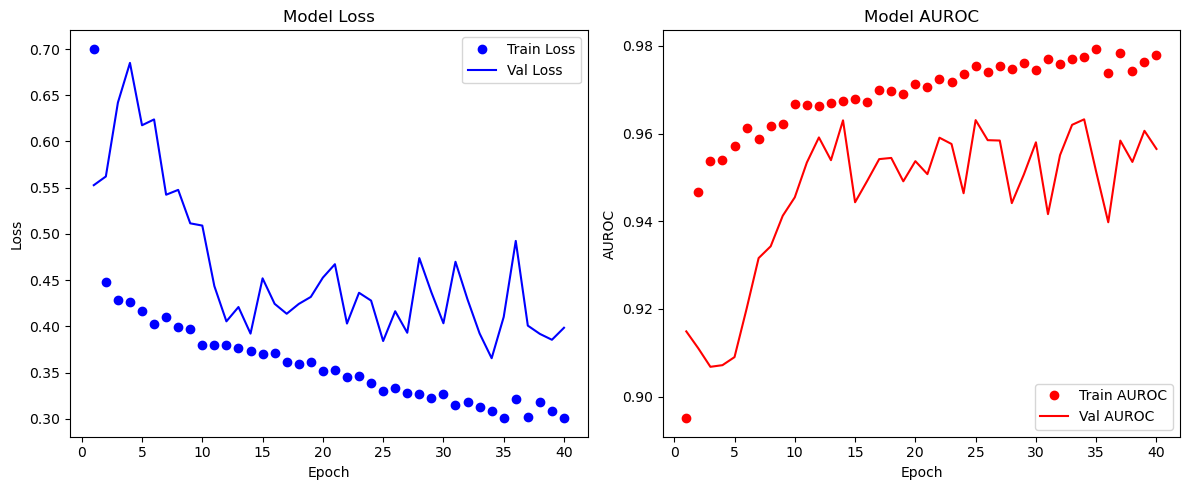

Maximum Validation AUROC = 0.9632 after epoch 34


In [54]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm7_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

Comments:
* lowering the learning rate did give slightly smoother validation curves, however they are still quite jagged.
* the best val-AUROC actually slipped to 0.9632 (decreased slightly).
* hence, the validation performance is still slightly unstable, AND with a lower ceiling.
* this model is beginning to overfit as the train perfomance looks to be continuing to improve, as the validation performance almost looks to curve back and get worse, diverging from the train. this could have been expected, as slower learning allows the model to learn more noise and hence decrease its ability to generalize.

Plan of Action:
* return to higher learning rate (0.001), as less overfitting, faster iterations, and can dial back down again if needed after adding the stronger regularization.
* often once a good level of regularisation has been found, we might be able to add another convolutional block or, as is done in the AlexNet and VGG-19 models, add a hidden layer between the flatten layer and the output layer, as regularisation often lets us scale our models to be larger than they could be without regularisation. This extra layer would need to be quite small to avoid explosions in parameter counts, but it seems to be a feature of many models. If we ended up adding more layers to our model, specifically to a point where we noticed that training became very unstable, we could add residual connections.
* however, we can already see the threat of overfitting in this model by decreasing the learning rate, which would be seen again if we add another layer.
* additionally, an extra layers should only be added if the AUROC still has room, and we want richer spatial features. given that the AUROC is already around 96-97%, it seems futile and potentially harmful to try and push this up anymore.
* as such, we will not utilise this method, but instead inject stronger regularization in the form of GlobalAveragePooling2D.
* Global Average Pooling collapses spatial information into a channel‐wise summary, slashes head parameters, and acts as an implicit regularizer, which is likely what our jagged val curves are calling us to do.
* we expect far fewer head weights, so there’s much less capacity to overfit, and hence validation loss spikes and AUROC volatility should smooth out.

### Model 8

In [46]:
keras.backend.clear_session()

inputs = tf.keras.Input(shape = (180,180,3)) 
x = conv_block_l2(x=inputs, K=2, filters=16, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=32, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, kernel_regularizer = l2(0.0005), activation = 'softmax')(x)

cvd_mdl8 = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl8.summary() 
    #GAP collapses the 11×11×64 feature-maps into 64 channels, so our final Dense(2) layer has 64×2 + 2 = 130 parameters.
    #this should help smooth out those validation spikes.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [47]:
%%time
# Compile the model
cvd_mdl8.compile(optimizer=Adam(learning_rate = 0.001),
              loss=CategoricalCrossentropy(), 
                metrics = [AUC(name='auroc', curve='ROC')] )

#Fit the model
cvd_mdl8.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10, 
    verbose = 1)

Epoch 1/40
171/171 [==============================] - 29s 166ms/step - loss: 0.4884 - auroc: 0.9284 - val_loss: 0.6833 - val_auroc: 0.7817
Epoch 2/40
171/171 [==============================] - 28s 165ms/step - loss: 0.4217 - auroc: 0.9470 - val_loss: 0.5165 - val_auroc: 0.9106
Epoch 3/40
171/171 [==============================] - 28s 165ms/step - loss: 0.3925 - auroc: 0.9508 - val_loss: 0.3668 - val_auroc: 0.9575
Epoch 4/40
171/171 [==============================] - 29s 168ms/step - loss: 0.3617 - auroc: 0.9553 - val_loss: 0.4810 - val_auroc: 0.9092
Epoch 5/40
171/171 [==============================] - 28s 165ms/step - loss: 0.3494 - auroc: 0.9548 - val_loss: 0.3392 - val_auroc: 0.9573
Epoch 6/40
171/171 [==============================] - 28s 165ms/step - loss: 0.3371 - auroc: 0.9552 - val_loss: 0.3430 - val_auroc: 0.9513
Epoch 7/40
171/171 [==============================] - 29s 167ms/step - loss: 0.3249 - auroc: 0.9562 - val_loss: 0.4198 - val_auroc: 0.9535
Epoch 8/40
171/171 [=======

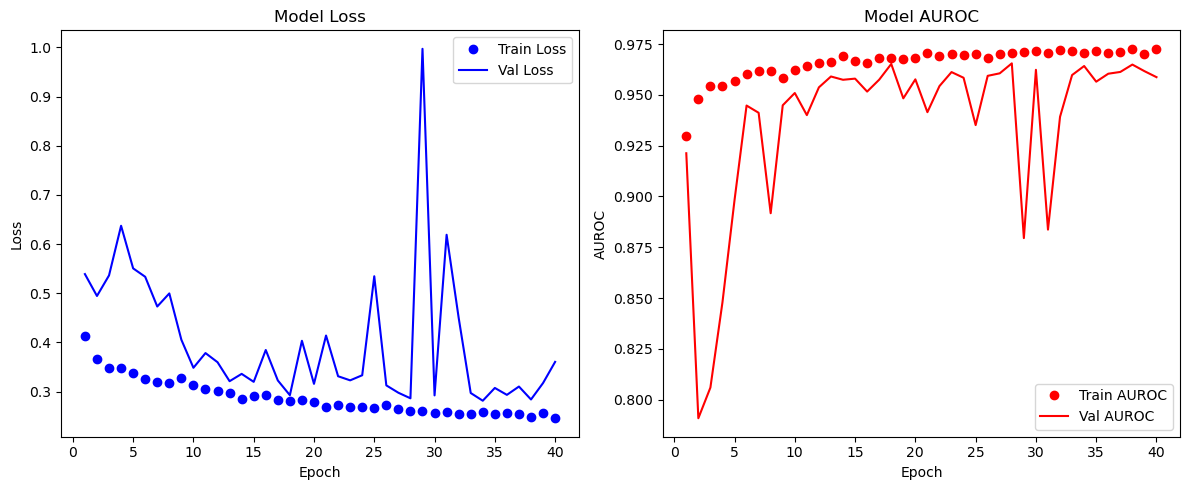

Maximum Validation AUROC = 0.9655 after epoch 28


In [58]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm8_history.pkl')
save_history(cvd_mdl8.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

Comments:
* there is no longer an issue of overfitting (gap between train and validate has closed significantly)
* the max AUROC achieved around epoch 28 is the best maximum we have reach so far, indicating this model provides the best performance.
* the validation perfomrance is much smoother. there is still 3-4 notable spikes, however we have to accept some of this volatility due to the inherently high variance in small‐batch dermoscopy images and subtle within‐class appearance changes that even a well‐regularized CNN can’t perfectly average out.

Suggests:
* the GAP has done its job.
* It has collapsed each 11×11×64 feature-map into a single scalar, drastically reducing the classifier head from ~7 744 inputs (≈15 490 params) down to 64 inputs (130 params), which has allowed the convolutional feature extractor to drive discrimination without overfitting in the dense layers.

Plan of Action:
* Now that the head is lightweight and generalizes well, our next tweaks should target any remaining volatility, e.g. adding a small Dropout (0.2–0.3) after the GAP layer
* In CNNs, dropout is typically applied after fully connected (dense) layers. If applied in the convolutional layers, it tends to do more harm than good, for example it destroys spatial consistency, reduces weight sharing benefits, and because conv layers usually have far fewer parameters than dense layers, the standard dropout rate needed to meaningfully regularize them would be so high that you’d cripple the layer’s representational power. *(De Luca & Aibin 2024)*.
* However, a small dropout (e.g. 0.2–0.3) helps by randomly disabling a fraction of the neurons during training, forcing the model to not rely too heavily on specific activations, and thereby encouraging more robust feature learning. In this case, the model’s head is lightweight and already generalizes reasonably well, but there's still some volatility in validation performance (e.g. oscillating loss or accuracy), and so dropout can act as a final regularization measure to stabilize training and improve reliability in clinical deployment.

### Model 9

In [59]:
keras.backend.clear_session()

inputs = tf.keras.Input(shape = (180,180,3)) 
x = conv_block_l2(x=inputs, K=2, filters=16, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=32, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) #20% dropout is lighter, so will preserve more signal
outputs = layers.Dense(2, kernel_regularizer = l2(0.0005), activation = 'softmax')(x)

cvd_mdl = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl.summary()  

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [60]:
%%time
# Compile the model
cvd_mdl.compile(optimizer=Adam(learning_rate = 0.001),
              loss=CategoricalCrossentropy(), 
                metrics = [AUC(name='auroc', curve='ROC')] )

#Fit the model
cvd_mdl.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 40, 
    verbose = 1)

Epoch 1/40
43/43 [==============================] - 57s 1s/step - loss: 0.6213 - auroc: 0.8706 - val_loss: 0.7145 - val_auroc: 0.9015
Epoch 2/40
43/43 [==============================] - 28s 641ms/step - loss: 0.4846 - auroc: 0.9322 - val_loss: 0.5949 - val_auroc: 0.9020
Epoch 3/40
43/43 [==============================] - 28s 647ms/step - loss: 0.4625 - auroc: 0.9389 - val_loss: 0.5405 - val_auroc: 0.9069
Epoch 4/40
43/43 [==============================] - 28s 643ms/step - loss: 0.4382 - auroc: 0.9454 - val_loss: 0.5247 - val_auroc: 0.9086
Epoch 5/40
43/43 [==============================] - 28s 640ms/step - loss: 0.4370 - auroc: 0.9442 - val_loss: 0.5819 - val_auroc: 0.9103
Epoch 6/40
43/43 [==============================] - 28s 656ms/step - loss: 0.4066 - auroc: 0.9523 - val_loss: 0.5237 - val_auroc: 0.9299
Epoch 7/40
43/43 [==============================] - 28s 657ms/step - loss: 0.3855 - auroc: 0.9572 - val_loss: 0.6232 - val_auroc: 0.9236
Epoch 8/40
43/43 [==========================

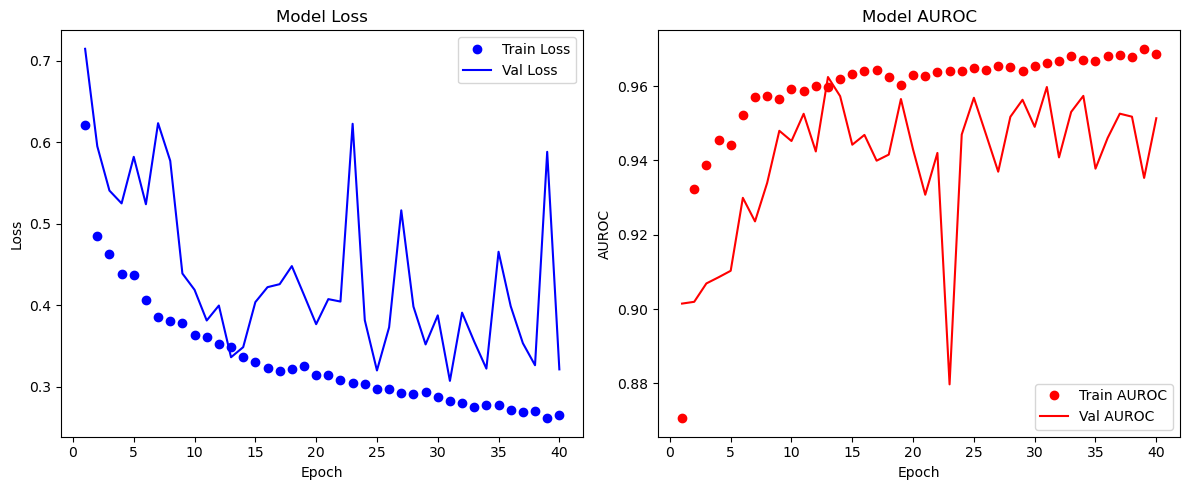

Maximum Validation AUROC = 0.9624 after epoch 13


In [61]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm9_history.pkl')
save_history(cvd_mdl.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

Comments:
* Dropout was applied in an aim to improve stability, but it actually led to a more unstable validation loss and AUROC.
* The validation AUROC peaked early (0.9624 at epoch 13) and then fluctuated heavily, suggesting that the model may have been over-regularized.
* As the model head was already lightweight, the added dropout likely disrupted learning rather than helping generalize.

Double dropout is another option that we often see applied throughout a range of similar case studies. However, as the training curves show that single‐layer dropout is ALREADY causing instability, introducing a second would likely discard more useful signal, encourage underfitting, and degrade both loss and AUROC. For these reasons, we won't add any more dropout layers, and will also not utilise this model with the single dropout.

Plan of Action:
* our current best model is model 8, with the 0.0005 L2 penalty, learning rate of 0.001, and GlobalAveragePooling. however, there is still slightly more volatility than we would like.
* we can return to a suggestion from earlier, which is once we now have a more strongly regularized model (with the L2 and GAP), we can try lowering the learning rate again.
* a common technique is to lower the learning rate after running a few epochs (for example 10). In the early stages of training, a higher learning rate allows the model to make larger updates, helping it escape poor local minima and quickly learn broad patterns. But as training progresses, large updates can cause the model to overshoot the optimal weights or introduce instability, especially near convergence. By reducing the learning rate later in the training timeline, we allow the model to take smaller, more precise steps, which helps fine-tune the weights, reduce oscillation, and improve generalization. This technique is often referred to as learning rate scheduling or decay.
* by doing this, we expect more stable training curves (especially validation loss and AUROC) and smoother convergence toward a better-performing model.

### Model 8 Extended

In [28]:
keras.backend.clear_session()

inputs = tf.keras.Input(shape = (180,180,3)) 
x = conv_block_l2(x=inputs, K=2, filters=16, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=32, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same',l2_wgt=0.0005, bn_bool=True)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, kernel_regularizer = l2(0.0005), activation = 'softmax')(x)

cvd_mdl81 = keras.Model(inputs=inputs, outputs=outputs)
cvd_mdl81.summary() 
    #GAP collapses the 11×11×64 feature-maps into 64 channels, so our final Dense(2) layer has 64×2 + 2 = 130 parameters.
    #this should help smooth out those validation spikes.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [29]:
cvd_mdl81.compile(optimizer=Adam(learning_rate=0.001),
                 loss=CategoricalCrossentropy(),
                 metrics=[AUC(name='auroc', curve='ROC')])

history1 = cvd_mdl81.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
171/171 [==============================] - 51s 284ms/step - loss: 0.5351 - auroc: 0.9090 - val_loss: 0.5436 - val_auroc: 0.9200
Epoch 2/10
171/171 [==============================] - 29s 167ms/step - loss: 0.4445 - auroc: 0.9397 - val_loss: 0.9468 - val_auroc: 0.6961
Epoch 3/10
171/171 [==============================] - 29s 166ms/step - loss: 0.4254 - auroc: 0.9398 - val_loss: 0.4814 - val_auroc: 0.8925
Epoch 4/10
171/171 [==============================] - 28s 165ms/step - loss: 0.3912 - auroc: 0.9467 - val_loss: 0.4345 - val_auroc: 0.9298
Epoch 5/10
171/171 [==============================] - 28s 165ms/step - loss: 0.3674 - auroc: 0.9512 - val_loss: 0.4946 - val_auroc: 0.9225
Epoch 6/10
171/171 [==============================] - 28s 165ms/step - loss: 0.3499 - auroc: 0.9536 - val_loss: 0.4832 - val_auroc: 0.9307
Epoch 7/10
171/171 [==============================] - 29s 166ms/step - loss: 0.3320 - auroc: 0.9567 - val_loss: 0.4067 - val_auroc: 0.9267
Epoch 8/10
171/171 [=======

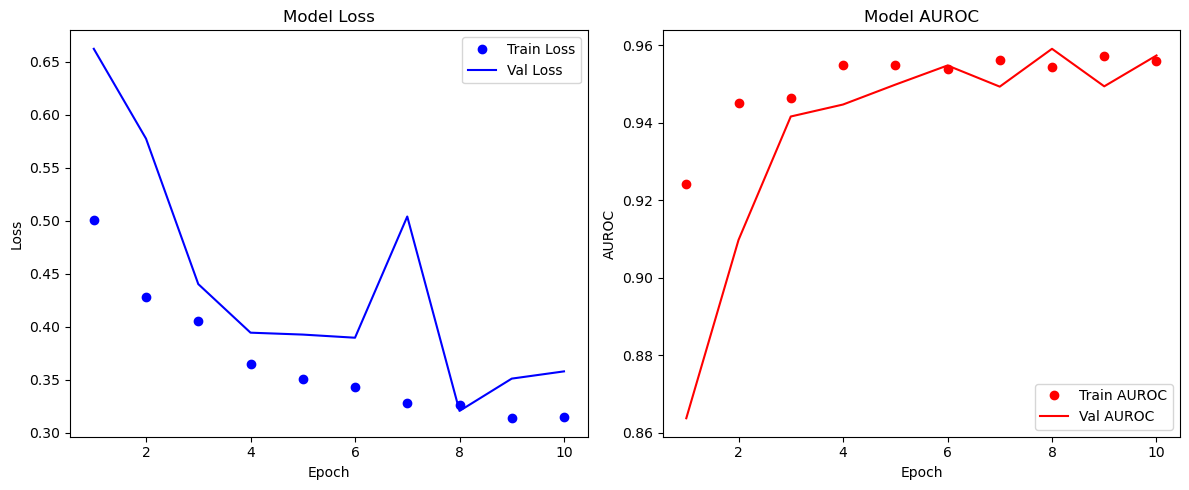

Maximum Validation AUROC = 0.9591 after epoch 8


In [23]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm81_history.pkl')
save_history(cvd_mdl81.history.history, history_path)

mdl_hstry = load_history(history_path)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

In [31]:
cvd_mdl81.compile(optimizer=Adam(learning_rate=0.0001), #decrease learning rate by a factor of 10
                 loss=CategoricalCrossentropy(),
                 metrics=[AUC(name='auroc', curve='ROC')])

history2 = cvd_mdl81.fit(
    train_ds,
    validation_data = val_ds,
    initial_epoch = 10,  # continues from previous
    epochs = 40,         # total of 10 + 30 = 40
    verbose = 1
)

Epoch 11/40
171/171 [==============================] - 29s 166ms/step - loss: 0.2973 - auroc: 0.9614 - val_loss: 0.2897 - val_auroc: 0.9633
Epoch 12/40
171/171 [==============================] - 29s 167ms/step - loss: 0.2884 - auroc: 0.9637 - val_loss: 0.2860 - val_auroc: 0.9642
Epoch 13/40
171/171 [==============================] - 29s 167ms/step - loss: 0.2857 - auroc: 0.9642 - val_loss: 0.2791 - val_auroc: 0.9655
Epoch 14/40
171/171 [==============================] - 36s 208ms/step - loss: 0.2836 - auroc: 0.9643 - val_loss: 0.3174 - val_auroc: 0.9583
Epoch 15/40
171/171 [==============================] - 29s 169ms/step - loss: 0.2791 - auroc: 0.9652 - val_loss: 0.2852 - val_auroc: 0.9639
Epoch 16/40
171/171 [==============================] - 28s 166ms/step - loss: 0.2767 - auroc: 0.9657 - val_loss: 0.2647 - val_auroc: 0.9686
Epoch 17/40
171/171 [==============================] - 29s 168ms/step - loss: 0.2748 - auroc: 0.9661 - val_loss: 0.2748 - val_auroc: 0.9660
Epoch 18/40
171/171 

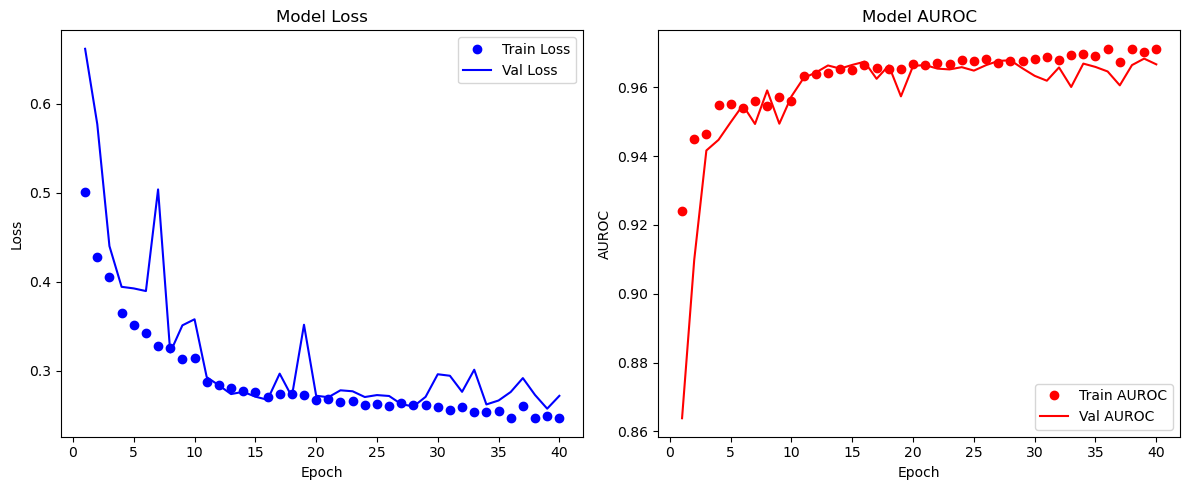

Maximum Validation AUROC = 0.9684 after epoch 39


In [25]:
history_dir  = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)           
history_path = os.path.join(history_dir, 'm81.2_history.pkl')
save_history(cvd_mdl81.history.history, history_path)

mdl_hstry = combine_histories(mdl_hstry, cvd_mdl81.history.history)
plot_training_auroc(mdl_hstry)
print_best_auroc(mdl_hstry)

#### MUCH BETTER - USE THIS MODEL
Comments:
* The training and validation loss curves show a smoother convergence compared to previous runs, with reduced noise and better alignment between training and validation performance.
* The validation AUROC reaches 0.9684, the highest achieved so far, and does so at epoch 39, indicating sustained improvement throughout training.
* The gap between training and validation AUROC is narrow, suggesting good generalization without overfitting.
* Volatility in the validation metrics is much lower, and there are no sharp drops as seen previously.

Suggests:
* The improved stability and performance likely stem from the reduction in learning rate after epoch 10, allowing the model to fine-tune its weights more precisely and avoid overshooting.
* This smoother training dynamic allowed the model to continue improving across later epochs, rather than peaking early and degrading.
* It suggests that the model benefits from a two-phase training schedule: fast learning early, followed by slow, stable convergence.
* These results confirm that the earlier instability was not due to model structure alone, but was likely driven by an overly aggressive learning rate in the later stages of training.
* Smoother loss curves confirm that BatchNorm + ReLU successfully counteract vanishing gradients, allowing deeper feature extraction without training stalls.

Plan of Action:
* we have reached our best model (model 8.1)
* we now want to explore three more alternative models, that deviate from our typical CNN building process. FIRST: we will try adding additional features into the model to see if it improves performance. SECOND: we will try a pre-trained model. THIRD: we will explore what other models have previously been utilised for similar lesion-classification tasks, to see if that yields any better performance.
* under some circumstances, it may be useful to begin by looking at these models so that you have a starting point, and then you can work from there. However, this classification task isn't too deep or complex, and hence our own CNN development proceedures sufficed. Additionaly, it was deemed important to show that clear pipeline of CNN development.
* after these additional have been explored, mainly for interests-sake, we will beginning looking at the predicitve performance of our chosen model, in addition to some common useful CNN visualizations. 

### Model 10 - Model with Features

There are many features available in the metadata, but not all are suitable to feed into the CNN. 
For example, we don’t want to use post-hoc features like 'diagnosis' or 'concomitant_biopsy' (data leakage), and features like 'lesion_id' and 'image_type' are just identifiers or technical modality flags (adds no predictive power). 'Attribution' and 'Copyright_license' are basically just provenance tags for who submitted or owns each image, not any clinical or biological property of the lesion or patient.
From our EDA, we investigated some key variables of 'Sex', 'Age', and 'Anatomical Site'. These are also the features that will be most useful in CNN. We have already confirmed that these variables do not introduce too much bias, as they are relatively evenly distributed. Anatomical site is slighly more inconsistent, with for example palms/soles have much fewer intances than lower extremities, however this is more expected due to the greater range of possibilities, and it still contains important predictive power. 
Namely, 'Age' and 'Anatomical Site' are very important due to the fact that the distribution of malignant and benign cases differ significantly across their classes, showing that they provide important signal about the outcome of the lesion sample. However, 'Sex' shows a fairly even split, suggesting that the chances of a beging or malignant lesion don't depend much on whether the patient is a male or female. Like ANNs, CNNs are data hungry and rely on lots of sample, however adding in useless features that don't hold much signal forces the model to learn noise and hence increases the risk of overfitting anf poor generalization. As such, I will choose to exclude 'Sex' from this model. A model could be tested with vs without 'Sex', as this is the most effective way to test its value, however for the scope of this task we will ignore it. 
The only remaining feature to consider is 'melanocytic', which although it looks clinical, is derived from expert or histology review and correlates almost perfectly with the target (non-melanocytic lesions are nearly always benign). Including it would again inflate performance by handing the model a near-perfect shortcut.
As such, a new model can now be trained that includes the tabular data of *'Age' and 'Anatomical Site'*. 

In [129]:
import pandas as pd
import numpy as np
import os
import shutil
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, regularizers, Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [130]:
file_details2 = file_details.dropna(subset=['age_approx']).reset_index(drop=True)

In [131]:
def stratified_ternary_split_df(df, ratios, label_col, seed=123):
    assert len(ratios) == 3, "Provide exactly three ratios"
    assert abs(sum(ratios) - 1.0) < 1e-6, "Ratios must sum to 1"

    r_train, r_val, r_test = ratios
    train_df, temp_df = train_test_split(df, train_size=r_train, stratify=df[label_col], random_state=seed)
    val_ratio_of_temp = r_val / (r_val + r_test)
    val_df, test_df = train_test_split(temp_df, train_size=val_ratio_of_temp, stratify=temp_df[label_col], random_state=seed)
    return train_df, val_df, test_df


def make_subset(df, split, dest_dir, src_dir):
    labels = df['classification'].unique()
    for label in labels:
        subfolder = os.path.join(dest_dir, split, label)
        os.makedirs(subfolder, exist_ok=True)
        sub_df = df[df['classification'] == label]
        for file_id in sub_df['file_id']:
            fname = f"{file_id}.jpg"
            src_path = os.path.join(src_dir, fname)
            dst_path = os.path.join(subfolder, fname)
            if os.path.exists(src_path):
                shutil.copyfile(src_path, dst_path)
            else:
                print(f"[WARNING] File not found: {src_path}")


train_files2, val_files2, test_files2 = stratified_ternary_split_df(
    file_details2, ratios=[0.7, 0.2, 0.1], label_col='classification', seed=123
)

In [1]:
#we want to standardize the features (specificlaly age, as it is numeric, and can range anywhere from 0 - 110 approx.)
scaler = StandardScaler()
train_files2['age_approx'] = scaler.fit_transform(train_files2[['age_approx']])
val_files2['age_approx']   = scaler.transform(val_files2[['age_approx']])
test_files2['age_approx']  = scaler.transform(test_files2[['age_approx']])

NameError: name 'StandardScaler' is not defined

In [133]:
meta_cols = ['age_approx', 'anatom_site_general']

# Training set
metadata_X = train_files2[meta_cols]
meta_num = metadata_X.select_dtypes(include=[float, int])
meta_cat = pd.get_dummies(metadata_X.select_dtypes(exclude=[float, int]), dtype=int)
X_meta_train = pd.concat([meta_num, meta_cat], axis=1)

# Validation
metadata_X = val_files2[meta_cols]
meta_num = metadata_X.select_dtypes(include=[float, int])
meta_cat = pd.get_dummies(metadata_X.select_dtypes(exclude=[float, int]), dtype=int)
meta_cat = meta_cat.reindex(columns=X_meta_train.columns.drop('age_approx'), fill_value=0)
X_meta_val = pd.concat([meta_num, meta_cat], axis=1)

# Test
metadata_X = test_files2[meta_cols]
meta_num = metadata_X.select_dtypes(include=[float, int])
meta_cat = pd.get_dummies(metadata_X.select_dtypes(exclude=[float, int]), dtype=int)
meta_cat = meta_cat.reindex(columns=X_meta_train.columns.drop('age_approx'), fill_value=0)
X_meta_test = pd.concat([meta_num, meta_cat], axis=1)

# Reattach to original DataFrames
train_files2[X_meta_train.columns] = X_meta_train
val_files2[X_meta_val.columns]     = X_meta_val
test_files2[X_meta_test.columns]   = X_meta_test

In [134]:
make_subset(train_files2, "train2", dest_dir=prep_folder, src_dir=orig_folder)
make_subset(val_files2, "val2", dest_dir=prep_folder, src_dir=orig_folder)
make_subset(test_files2, "test2", dest_dir=prep_folder, src_dir=orig_folder)

In [135]:
train_ds_raw = image_dataset_from_directory(
    directory=os.path.join(prep_folder, "train2"),
    image_size=(180, 180),
    batch_size=32,
    labels='inferred'
)

val_ds_raw = image_dataset_from_directory(
    directory=os.path.join(prep_folder, "val2"),
    image_size=(180, 180),
    batch_size=32,
    labels='inferred'
)

Found 5420 files belonging to 2 classes.
Found 1548 files belonging to 2 classes.


In [136]:
def get_file_ids_from_dataset(ds):
    return [os.path.splitext(os.path.basename(path))[0] for path in ds.file_paths]

train_file_ids = get_file_ids_from_dataset(train_ds_raw)
val_file_ids = get_file_ids_from_dataset(val_ds_raw)

# Match the metadata
train_meta = train_files2.set_index("file_id").loc[train_file_ids][X_meta_train.columns].values
val_meta   = val_files2.set_index("file_id").loc[val_file_ids][X_meta_val.columns].values


# Convert classification to 0/1 labels
label_map = {'benign': 0, 'malignant': 1}
train_labels = train_files2.set_index("file_id").loc[train_file_ids]['classification'].map(label_map).values
val_labels   = val_files2.set_index("file_id").loc[val_file_ids]['classification'].map(label_map).values

In [137]:
def create_combined_dataset(image_ds, meta_array, label_array, batch_size=32):
    image_ds = image_ds.map(lambda img, label: img).unbatch()
    meta_ds = tf.data.Dataset.from_tensor_slices(meta_array)
    label_ds = tf.data.Dataset.from_tensor_slices(label_array)
    full_ds = tf.data.Dataset.zip(((image_ds, meta_ds), label_ds))
    return full_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = create_combined_dataset(train_ds_raw, train_meta, train_labels)
val_ds = create_combined_dataset(val_ds_raw, val_meta, val_labels)

In [138]:
print(type(train_ds))
print(sys.getsizeof(train_ds))

for (image_batch, meta_batch), labels_batch in train_ds:
    print("Image batch shape:", image_batch.shape)
    print("Metadata batch shape:", meta_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
48
Image batch shape: (32, 180, 180, 3)
Metadata batch shape: (32, 7)
Labels batch shape: (32,)


In [139]:
keras.backend.clear_session()

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
], name="data_augmentation")

img_input = Input(shape=(180, 180, 3), name='img_input')
meta_input = Input(shape=(7,), name='meta_input')  # Adjust shape to match metadata

x = data_augmentation(img_input)
x = conv_block_l2(x=img_input, K=2, filters=16, size=3, stride=1, padding='same', l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=32, size=3, stride=1, padding='same', l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same', l2_wgt=0.0005, bn_bool=True)
x = conv_block_l2(x=x, K=2, filters=64, size=3, stride=1, padding='same', l2_wgt=0.0005, bn_bool=True)
x = layers.GlobalAveragePooling2D()(x)

combined = layers.concatenate([x, meta_input])
outputs = layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.0005))(combined)

cvd_mdl = Model(inputs=[img_input, meta_input], outputs=outputs)
cvd_mdl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 180, 16  432         ['img_input[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 180, 180, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [140]:
cvd_mdl.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=SparseCategoricalAccuracy()
)

cvd_mdl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    verbose=1
)

Epoch 1/40
170/170 [==============================] - 8s 44ms/step - loss: 0.5389 - sparse_categorical_accuracy: 0.8559 - val_loss: 0.5653 - val_sparse_categorical_accuracy: 0.8527
Epoch 2/40
170/170 [==============================] - 7s 44ms/step - loss: 0.4954 - sparse_categorical_accuracy: 0.8561 - val_loss: 0.4821 - val_sparse_categorical_accuracy: 0.8605
Epoch 3/40
170/170 [==============================] - 7s 44ms/step - loss: 0.4570 - sparse_categorical_accuracy: 0.8583 - val_loss: 0.4496 - val_sparse_categorical_accuracy: 0.8598
Epoch 4/40
170/170 [==============================] - 7s 44ms/step - loss: 0.4306 - sparse_categorical_accuracy: 0.8600 - val_loss: 0.4461 - val_sparse_categorical_accuracy: 0.8559
Epoch 5/40
170/170 [==============================] - 7s 44ms/step - loss: 0.4113 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.3980 - val_sparse_categorical_accuracy: 0.8605
Epoch 6/40
170/170 [==============================] - 7s 44ms/step - loss: 0.3963 - sparse_cate

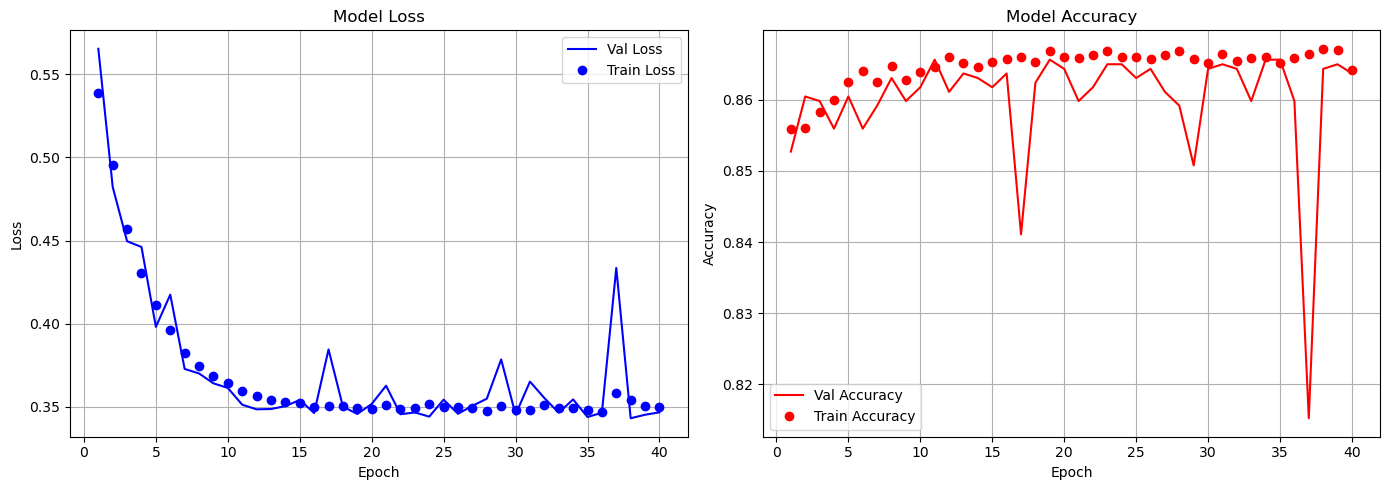

Maximum Validation Accuracy = 0.8656 after epoch 11


In [141]:
history_dir = os.path.join(core_path, 'Saved Models')
os.makedirs(history_dir, exist_ok=True)
history_path = os.path.join(history_dir, 'm9_history.pkl')
save_history(cvd_mdl.history.history, history_path)

def plot_training_loss_and_accuracy(history_dict):
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    train_acc = history_dict['sparse_categorical_accuracy']
    val_acc = history_dict['val_sparse_categorical_accuracy']
    epochs = range(1, len(train_loss) + 1)
    best_epoch = int(np.argmax(val_acc)) + 1
    best_val_acc = val_acc[best_epoch - 1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(epochs, val_loss, color='blue', label='Val Loss')
    ax1.plot(epochs, train_loss, 'bo', label='Train Loss')
    ax1.set_title('Model Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
    ax2.plot(epochs, val_acc, color='red', label='Val Accuracy')
    ax2.plot(epochs, train_acc, 'ro', label='Train Accuracy')
    ax2.set_title('Model Accuracy'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)
    plt.tight_layout(); plt.show()
    print(f"Maximum Validation Accuracy = {best_val_acc:.4f} after epoch {best_epoch}")

mdl_hstry = load_history(history_path)
plot_training_loss_and_accuracy(mdl_hstry)

In [142]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Initialize lists to store true labels and predicted probabilities
y_val_true = []
y_val_pred_probs = []

# Loop through the validation dataset and gather predictions
for (img_batch, meta_batch), label_batch in val_ds:          
    preds = cvd_mdl.predict((img_batch, meta_batch), verbose=0)
    y_val_true.extend(label_batch.numpy())                   # actual labels (0 or 1)
    y_val_pred_probs.extend(preds[:, 1])                     # predicted prob for class 1

# Convert to numpy arrays (recommended)
y_val_true = np.array(y_val_true)
y_val_pred_probs = np.array(y_val_pred_probs)

# Calculate AUROC
val_auc_score = roc_auc_score(y_val_true, y_val_pred_probs)
print(f"Validation AUROC: {val_auc_score:.4f}")


Test AUROC: 0.7749


Commnets:
* this model DOES NOT appear to be too bad.
* in comparison to many of the previous models, it is relatively stable (apart from ~3 strong spikes in accuracy), however is not on par with model 8.1 (which is EXTREMELY stable).
* the loss is actually MORE stable than our model 8.1.
* the model reaches peak performance VERY quickly (with accuracy maxing at epoch 11, and performance looking quite high by epoch 5).
* it is difficult to compare this with other models as we are unable to plot AUROC due to switching from a single-input (image, label) pipeline to a dual-input ((image, meta), label) pipeline, where Keras automatically handles accuracy but silently drops the stock AUC metric unless it is re-declared with the correct input signature. In addition, the final layer changed from a single-unit sigmoid to a two-unit soft-max after metadata was introduced. The helper that used to call roc_curve on model.predict() now gets an (N, 2) array and fails unless you pick the positive-class column. As such, rather than rewrite the helper mid-deadline, the simplest path was to plot accuracy (which is unaffected by the output shape) and compute AUROC separately once per model.
* the separately computed validation AUROC however also presents as lower than that achieved by model 8.1 (this is our MOST important metric to consider at the moment)

Suggests:
* the added metadata cues appear to add a small but real signal, as they help the net converge faster.
* the tabular features explain part of the class boundary up-front (e.g., melanomas are rarer on the scalp and in teenagers). That means the CNN doesn’t have to discover those patterns solely from pixels, so gradient updates carry less random error. In addition, mixing heterogenous inputs works like a mild regulariser, as gradients have to agree across modalities, which discourages the network from memorising noise in any one branch. This afforded the extremely stable LOSS curve.

Plan of Action:
* this model is good, however model 8.1 is still our best (performance like the accuracy plot (more smooth), and the AUROC metric (higher) is more important for this scenario.)
* in addition, adding these metadata variables DOES increase the risk of the network learning a default decision boundary that works great on the majority but degrades elsewhere, or of the model seeing correlations in the data and beginning to rely on them even when the image signal is ambiguous (if the data is not handelled carefully).
* this has been a good extension to the model investigation, but model 8.1 will still be favoured moving forwards.
  

### Model 11 - Pre-Trained Model

#### What are Pre-Trained Models and Why Do We Use Them?
Pre-trained models are neural networks that have already been trained on large, general-purpose datasets (such as ImageNet, which contains over 14 million images). Instead of training a model from scratch, we typically use these models as a starting point.
For us however, we have decided to included this at the end of the modeling process as a benchmark model to compare the performance of our custom architecture against a well-established, pre-trained standard. Rather than relying on it to guide model development, we used it to evaluate whether our own CNN design could match or outperform a widely used industry baseline.
Using ResNet50 in this way provides:
* External validation: It helps assess whether our model is competitive with state-of-the-art architectures trained on large-scale datasets.
* A sanity check: If ResNet50 performs significantly better, it may indicate that our custom model is missing key representational capacity. If our model performs similarly or better, it supports the strength and appropriateness of our design.
This approach strengthens the credibility of our results without shifting focus away from the goal of building a lightweight, task-specific solution.

#### Why ResNet50?
We chose ResNet50 because it is a reliable, widely adopted CNN architecture that performs well in transfer learning tasks. It includes 50 layers and is built around residual connections, which help stabilize deep networks during training by preventing vanishing gradients. ResNet50 is also pre-trained on ImageNet, making it capable of extracting rich, general-purpose features that are useful for classifying medical images like skin lesions.
Compared to other architectures, ResNet50 offers a strong balance between performance and efficiency, making it suitable for our use case without requiring excessive computational resources.

In [39]:
# Build & compile the transfer-learning model (feature-extraction only) 
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

base = ResNet50(include_top=False, weights="imagenet", input_shape=(*img_size, 3))
base.trainable = False   # <-- freeze the entire convolutional base

inp = layers.Input(shape=(*img_size,3))
x   = base(inp, training=False)            # run in inference mode
x   = layers.GlobalAveragePooling2D()(x)
x   = layers.Dense(256, activation="relu")(x)
x   = layers.Dropout(0.5)(x)
out = layers.Dense(2, activation="softmax")(x)

model = Model(inp, out, name="resnet50_featext")
model.compile(
    optimizer=Adam(1e-3),
    loss=CategoricalCrossentropy(),
    metrics=[AUC(name="auroc", curve="ROC")]
)

model.summary()


Model: "resnet50_featext"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                  

In [40]:
# Train head only 
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,     
    verbose=1,
)

Epoch 1/10
171/171 [==============================] - 51s 266ms/step - loss: 0.4504 - auroc: 0.8582 - val_loss: 0.4185 - val_auroc: 0.8572
Epoch 2/10
171/171 [==============================] - 29s 168ms/step - loss: 0.4260 - auroc: 0.8601 - val_loss: 0.4219 - val_auroc: 0.8646
Epoch 3/10
171/171 [==============================] - 29s 168ms/step - loss: 0.4260 - auroc: 0.8584 - val_loss: 0.4140 - val_auroc: 0.9223
Epoch 4/10
171/171 [==============================] - 29s 169ms/step - loss: 0.4202 - auroc: 0.8637 - val_loss: 0.4061 - val_auroc: 0.9235
Epoch 5/10
171/171 [==============================] - 29s 168ms/step - loss: 0.4233 - auroc: 0.8580 - val_loss: 0.4101 - val_auroc: 0.9309
Epoch 6/10
171/171 [==============================] - 29s 168ms/step - loss: 0.4249 - auroc: 0.8580 - val_loss: 0.4040 - val_auroc: 0.9305
Epoch 7/10
171/171 [==============================] - 29s 167ms/step - loss: 0.4145 - auroc: 0.8664 - val_loss: 0.4015 - val_auroc: 0.9361
Epoch 8/10
171/171 [=======

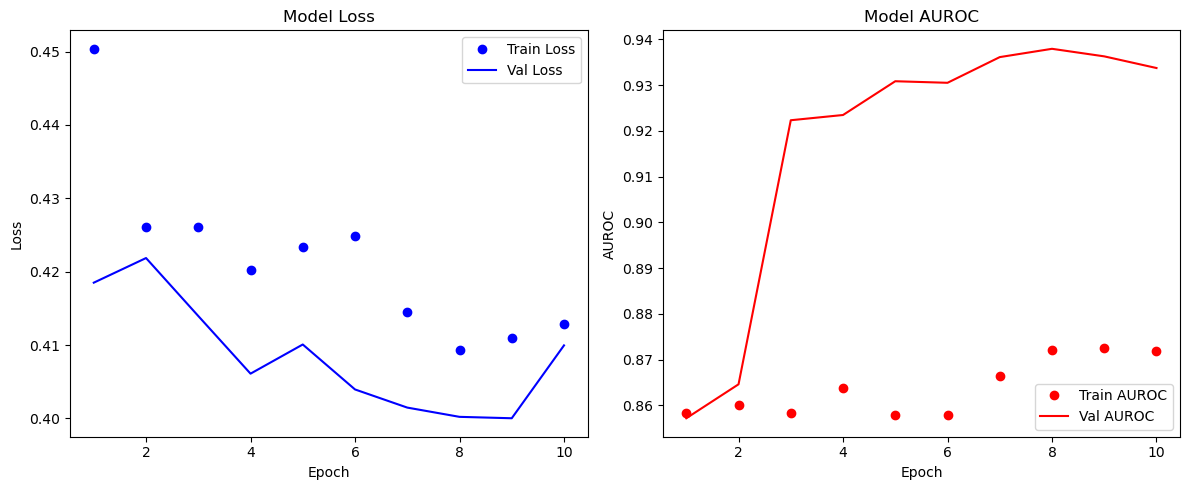

Maximum Validation AUROC = 0.9380 after epoch 8


In [41]:
#Save & plot history 
history_dir = os.path.join(core_path, "Saved Models")
os.makedirs(history_dir, exist_ok=True)
hist_path = os.path.join(history_dir, "m11_history.pkl")

save_history(history.history, hist_path)
h = load_history(hist_path)

plot_training_auroc(h)
print_best_auroc(h)

Comments:
* This model uses ResNet50 as a frozen feature extractor, meaning the convolutional base is not trainable and only the top classification layers are updated.
* Validation AUROC reaches 0.9380 after epoch 8, showing that even without fine-tuning, the pre-trained features from ResNet50 are highly effective for this task.
* Both loss and AUROC curves are relatively stable, though validation loss shows a mild upward trend after epoch 8.

Suggests:
* The model benefits from transfer learning, leveraging general features learned from ImageNet for medical images.
* The flattening of performance by epoch 10 indicates the model has likely plateaued, limited by the frozen base.
* This result provides a strong starting benchmark, but to push performance further, we move on to fine-tuning, where we unfreeze and retrain some or all of the ResNet50 layers to specialize them for lesion classification.

Plan of Action:
* follow on to the fine-tuning of this.

In [42]:
# 1) Unfreeze top of the base
base.trainable = True
fine_tune_at = 140   # e.g. unfreeze from this layer onward
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

# 2) Re-compile with lower LR
model.compile(
    optimizer=Adam(1e-4),
    loss=CategoricalCrossentropy(),
    metrics=[AUC(name="auroc", curve="ROC")]
)

# 3) Continue training
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,   # or however many you need until val_auroc plateaus
    verbose=1
)


Epoch 1/10
171/171 [==============================] - 33s 180ms/step - loss: 0.4219 - auroc: 0.8599 - val_loss: 0.4094 - val_auroc: 0.8571
Epoch 2/10
171/171 [==============================] - 29s 168ms/step - loss: 0.4190 - auroc: 0.8602 - val_loss: 0.4197 - val_auroc: 0.8566
Epoch 3/10
171/171 [==============================] - 29s 169ms/step - loss: 0.4150 - auroc: 0.8618 - val_loss: 0.4102 - val_auroc: 0.8586
Epoch 4/10
171/171 [==============================] - 29s 170ms/step - loss: 0.4145 - auroc: 0.8580 - val_loss: 0.4090 - val_auroc: 0.8600
Epoch 5/10
171/171 [==============================] - 29s 169ms/step - loss: 0.4128 - auroc: 0.8605 - val_loss: 0.4086 - val_auroc: 0.8949
Epoch 6/10
171/171 [==============================] - 29s 168ms/step - loss: 0.4132 - auroc: 0.8597 - val_loss: 0.4083 - val_auroc: 0.8682
Epoch 7/10
171/171 [==============================] - 29s 169ms/step - loss: 0.4118 - auroc: 0.8631 - val_loss: 0.4061 - val_auroc: 0.9265
Epoch 8/10
171/171 [=======

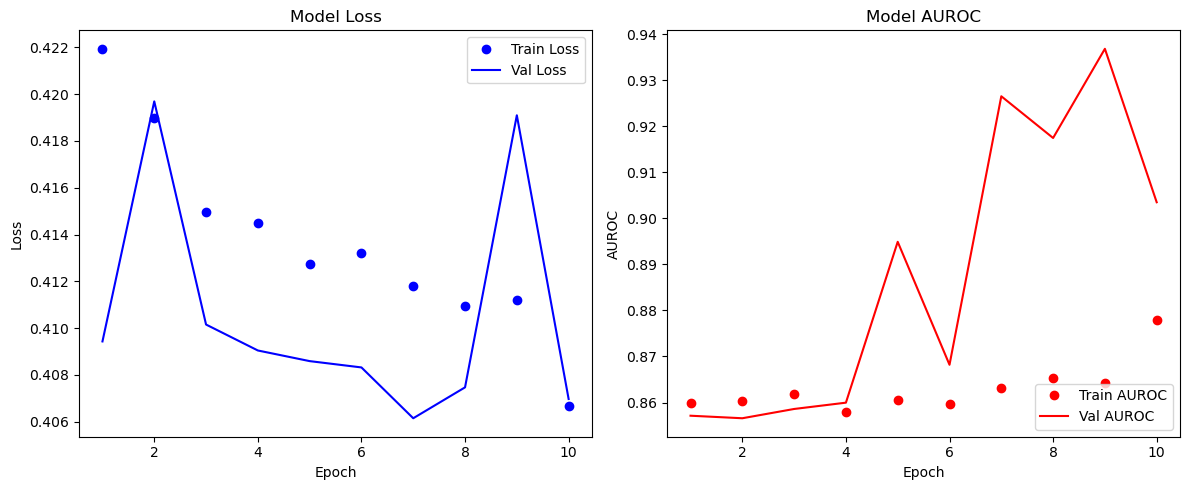

Maximum Validation AUROC = 0.9368 after epoch 9


In [44]:
# overwrite your pickle with the fine-tune history
save_history(history_ft.history, hist_path)

# reload and plot
h = load_history(hist_path)
plot_training_auroc(h)
print_best_auroc(h)

Comments:
* This model unfreezes the top layers of ResNet50 for fine-tuning, allowing the pre-trained base to adjust to the skin lesion data.
* The maximum validation AUROC reached 0.9368 at epoch 9, which is similar to the feature extraction model.
* Loss values are relatively flat, and AUROC curves are noisy, with frequent spikes and dips in validation performance.

Suggests:
* Fine-tuning introduced more variability, possibly due to a learning rate that was too high for the newly trainable layers.
* There was no significant performance gain over the frozen version, indicating that the pre-trained weights were already well-suited to the task.
* The erratic AUROC trend suggests the model may benefit from a lower learning rate, longer training, or gradual unfreezing (layer-by-layer), rather than full fine-tuning all at once.

Plan of Action:
* Model 8.1 outperforms the fine-tuned ResNet50 in terms of stability, reliability, and overall AUROC. While the fine-tuned ResNet50 reaches a maximum validation AUROC of 0.9368, it suffers from instability and erratic fluctuations, suggesting poor convergence and potential overfitting or learning rate mismatch. In contrast, Model 8.1 achieves a higher AUROC (0.9684) with smoother training curves, clear convergence, and minimal validation noise.
* The comparison highlights that: our custom model generalizes better and is more robust on this task, fine-tuning ResNet50 did not yield added value, despite its complexity and pre-training, the performance of Model 8.1 shows that a lighter, task-specific architecture, when tuned carefully, can outperform larger pre-trained models on domain-specific data.
* This validates our architectural and training choices, and supports the decision to use Model 8.1 as the final selected model.

### Model 12 - Research Model

The research model chosen was from the project *Skin Lesion Classification of Dermoscopic Images Using Machine Learning and CNN* by Shetty et al. (2022). 
This study evaluates various machine learning methods—including classical algorithms (SVM, RF, KNN, etc.) and Convolutional Neural Networks (CNNs)—to classify dermoscopic skin lesion images from the HAM10000 dataset (10,015 images across seven diagnostic categories). (in this way, it is slightly different to our task, as we are only doing a binary classification - malignant or benign, and hence the final dense layer will require adjustment). 

Their model architecture was as follows: 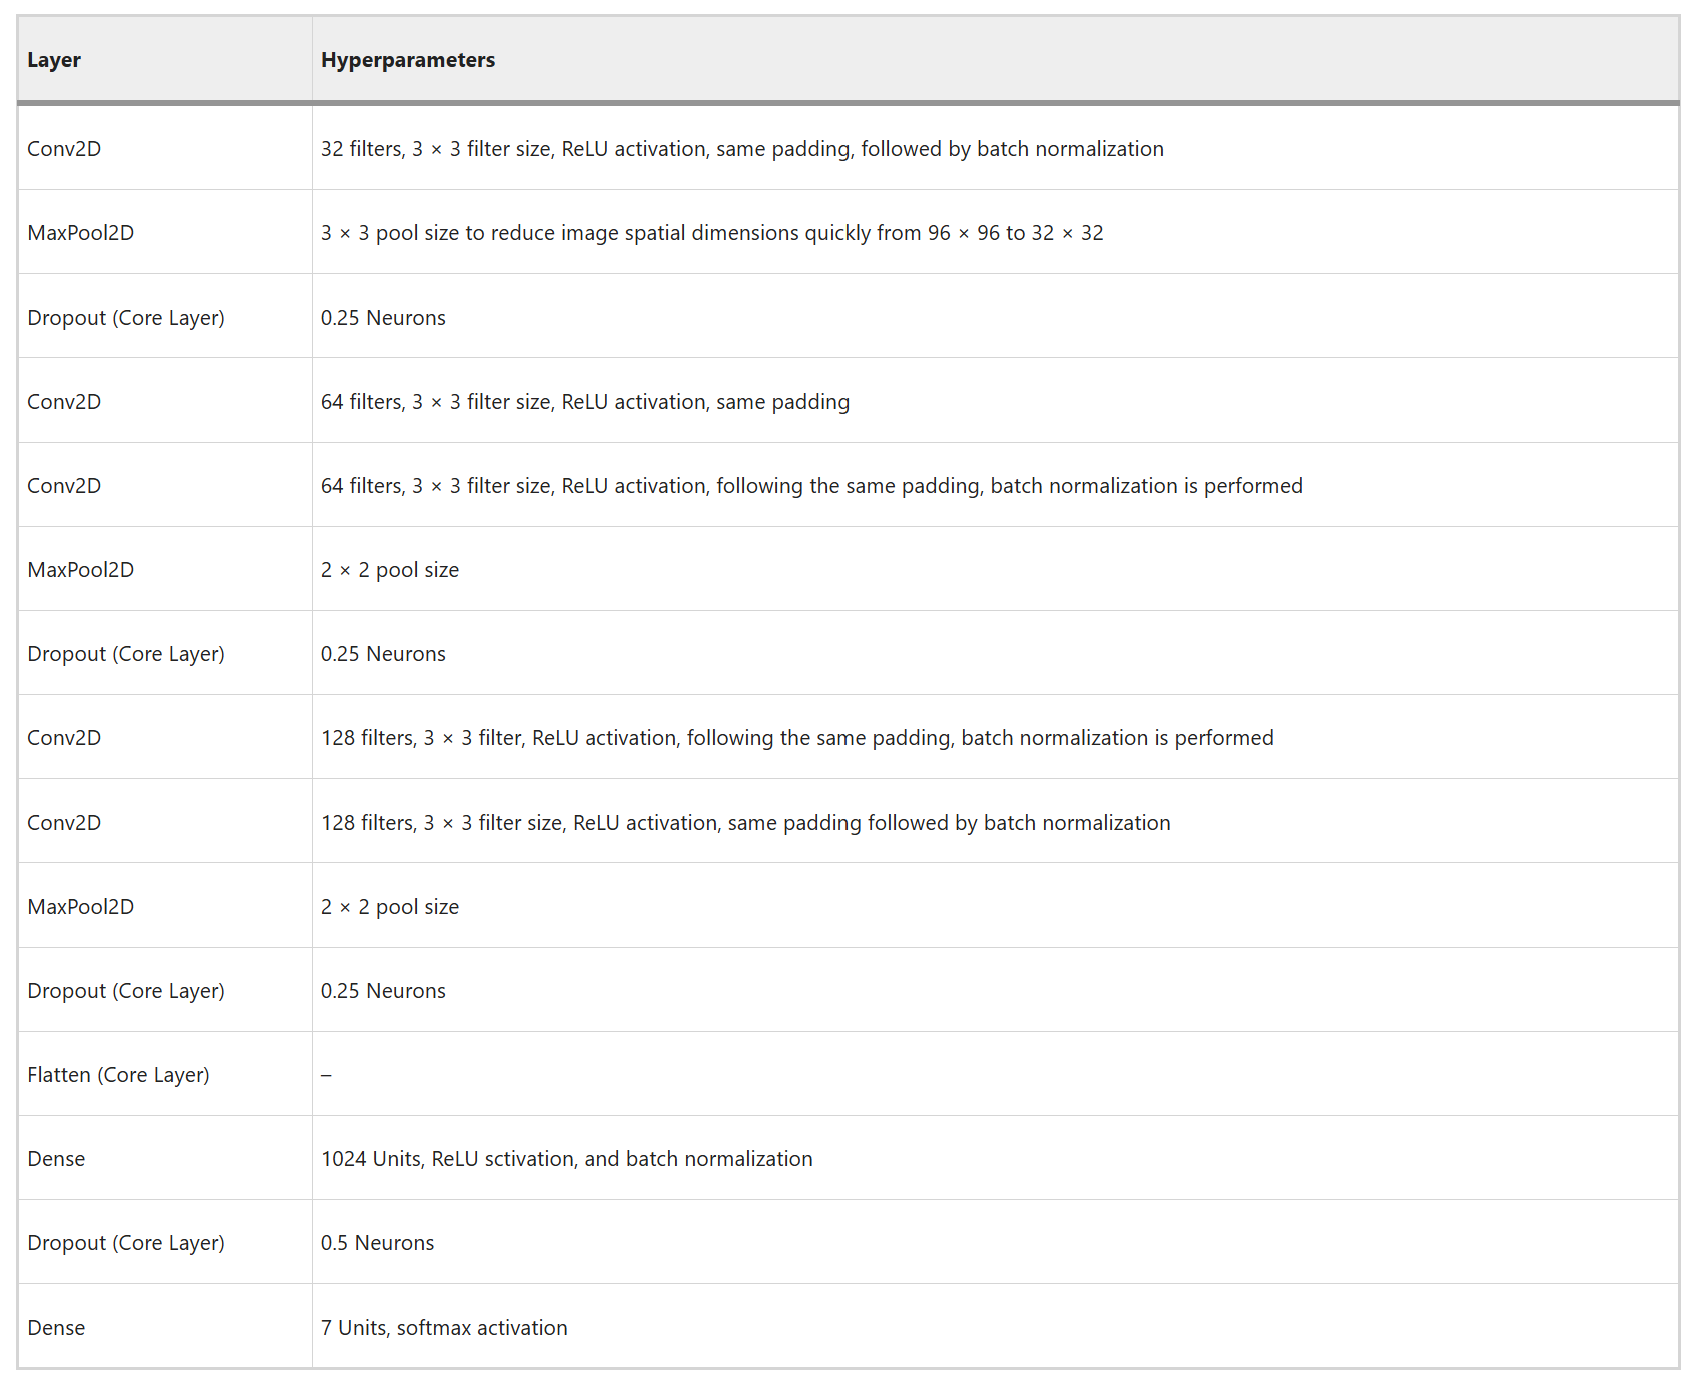 

The reasoning for their chosen hyperparamteres is as follows:

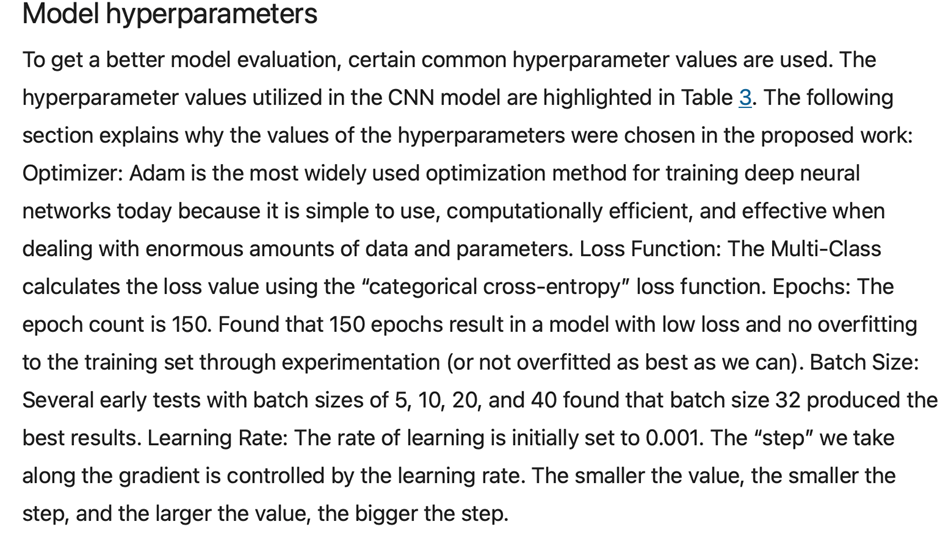

In [143]:
#changing my data generator code to match the image and batch size of the other researcher's code:

core_path = "C:/Users/13973865/OneDrive - Bond University/deep learning/assignment 2/"
orig_folder = core_path + "ISIC Data/ISIC Data/"

train_files['filename'] = train_files['file_id'] + '.jpg'
val_files['filename']   = val_files['file_id'] + '.jpg'
test_files['filename']  = test_files['file_id'] + '.jpg'

aug_gen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen2  = ImageDataGenerator(rescale=1./255)
test_gen2 = ImageDataGenerator(rescale=1./255)

train_gen2 = aug_gen2

# Set new batch size & target size
batch_size = 32
img_size   = (220, 220)

# Create the flows using train_files/val_files/test_files
train_ds2 = train_gen2.flow_from_dataframe(
    dataframe = train_files, 
    directory = orig_folder,
    x_col     = 'filename',
    y_col     = 'classification',
    target_size = img_size,
    batch_size  = batch_size,
    shuffle      = True,
    class_mode   = 'categorical'
)

val_ds2 = val_gen2.flow_from_dataframe(
    dataframe = val_files, 
    directory = orig_folder,
    x_col     = 'filename',
    y_col     = 'classification',
    target_size = img_size,
    batch_size  = batch_size,
    shuffle      = False,
    class_mode   = 'categorical'
)

test_ds2 = test_gen2.flow_from_dataframe(
    dataframe = test_files, 
    directory = orig_folder, 
    x_col     = 'filename',
    y_col     = 'classification',
    target_size = img_size,
    batch_size  = batch_size,
    shuffle      = False,
    class_mode   = 'categorical'
)

Found 5472 validated image filenames belonging to 2 classes.
Found 1564 validated image filenames belonging to 2 classes.
Found 782 validated image filenames belonging to 2 classes.


In [144]:
# Build & compile the **binary** CNN from Table (that depicts model), with 2‐way softmax 
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import CategoricalCrossentropy
from tensorflow.keras.metrics    import AUC

K.clear_session()

inp = layers.Input(shape=(*img_size, 3), name="input_image")

# Block 1: Conv32 → BN → ReLU → MaxPool(3×3) → Dropout(0.25)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Dropout(0.25)(x)

# Block 2: Conv64 → ReLU → Conv64 → ReLU → BN → MaxPool(2×2) → Dropout(0.25)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.25)(x)

# Block 3: Conv128 → ReLU → Conv128 → ReLU → BN → MaxPool(2×2) → Dropout(0.25)
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.25)(x)

# Head: Flatten → Dense(1024)→BN→ReLU → Dropout(0.5) → Dense(2)→Softmax
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(2, activation="softmax", name="predictions")(x)

model = Model(inputs=inp, outputs=out, name="cnn_binary_220")


model.summary()


Model: "cnn_binary_220"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 220, 220, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 64)     

In [145]:
%%time

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(),
    metrics=[AUC(name="auroc", curve="ROC")]
)

history = model.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=150,
    verbose=1
)

Epoch 1/150
171/171 [==============================] - 40s 227ms/step - loss: 0.6219 - auroc: 0.8392 - val_loss: 4.9233 - val_auroc: 0.8574
Epoch 2/150
171/171 [==============================] - 37s 218ms/step - loss: 0.3915 - auroc: 0.9181 - val_loss: 11.2478 - val_auroc: 0.8574
Epoch 3/150
171/171 [==============================] - 37s 217ms/step - loss: 0.3455 - auroc: 0.9314 - val_loss: 0.3828 - val_auroc: 0.9101
Epoch 4/150
171/171 [==============================] - 37s 218ms/step - loss: 0.3254 - auroc: 0.9369 - val_loss: 0.3504 - val_auroc: 0.9255
Epoch 5/150
171/171 [==============================] - 37s 217ms/step - loss: 0.2980 - auroc: 0.9457 - val_loss: 1.1397 - val_auroc: 0.8362
Epoch 6/150
171/171 [==============================] - 37s 219ms/step - loss: 0.2917 - auroc: 0.9481 - val_loss: 1.9984 - val_auroc: 0.7901
Epoch 7/150
171/171 [==============================] - 37s 217ms/step - loss: 0.2957 - auroc: 0.9473 - val_loss: 0.4704 - val_auroc: 0.9330
Epoch 8/150
171/171

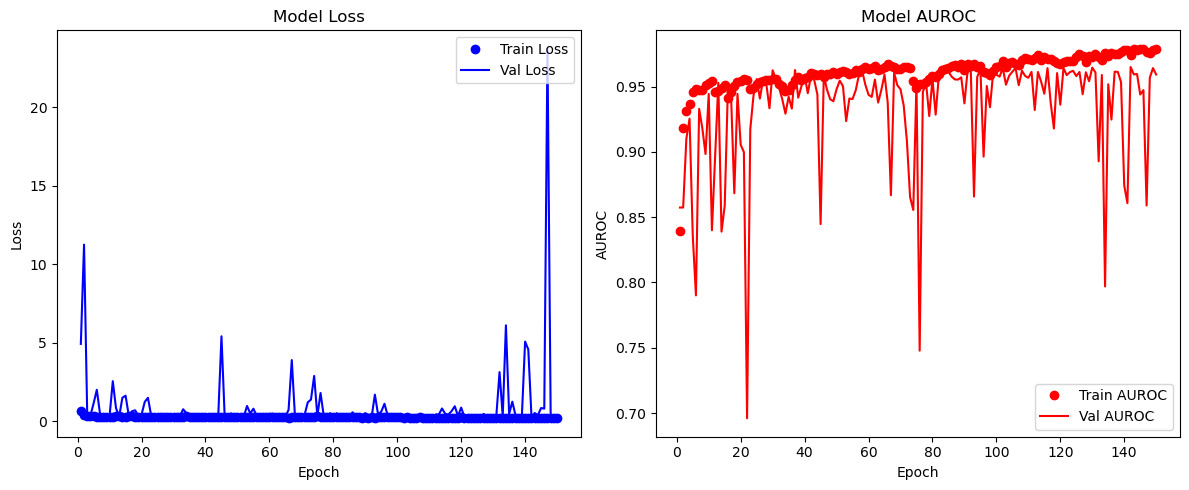

Maximum Validation AUROC = 0.9658 after epoch 84


In [146]:
# Save & plot history
history_dir = os.path.join(core_path, "Saved Models")
os.makedirs(history_dir, exist_ok=True)
hist_path = os.path.join(history_dir, "m12_history.pkl")

save_history(history.history, hist_path)
h = load_history(hist_path)

plot_training_auroc(h)
print_best_auroc(h)

Comments:
* this model is again not too bad.
* its max AUROC is JUST below that of model 8.1
* the loss improves VERY quickly, showing that the network becomes extremely confident early.
* however, it is MORE unstable
* due to the 150 epochs, it also takes a LONG TIME to run, and MUCH longer to reach peak AUROC performance (epoch 84), which is more unfeasible for practical application, meaning deploying this model would require longer compute budgets and careful AUROC-based early stopping

Plan of Action:
* this was again a good extension to our investigiation, and it turned out to be quite a good model, however for the sake of feasibilty, and STILL a slightly higher AUROC, model 8.1 remains the best model. However, this definetly highlights how transferable and useful external models can be in model developmemt. 

## Predictions
The predictions assign each input image a probability of being benign or malignant, enabling the model to classify lesions. 
The predictions are useful for evaluating model performance as they allow us to calculate key metrics like AUROC, accuracy, precision, and recall, which reflect how well the model distinguishes between benign and malignant lesions. These metrics help assess both the model's diagnostic effectiveness and its generalization to unseen data.

As it was chosen as the best final model, these predictions will be based on MODEL 8.1. 

1/1 [==============================] - 0s 14ms/step


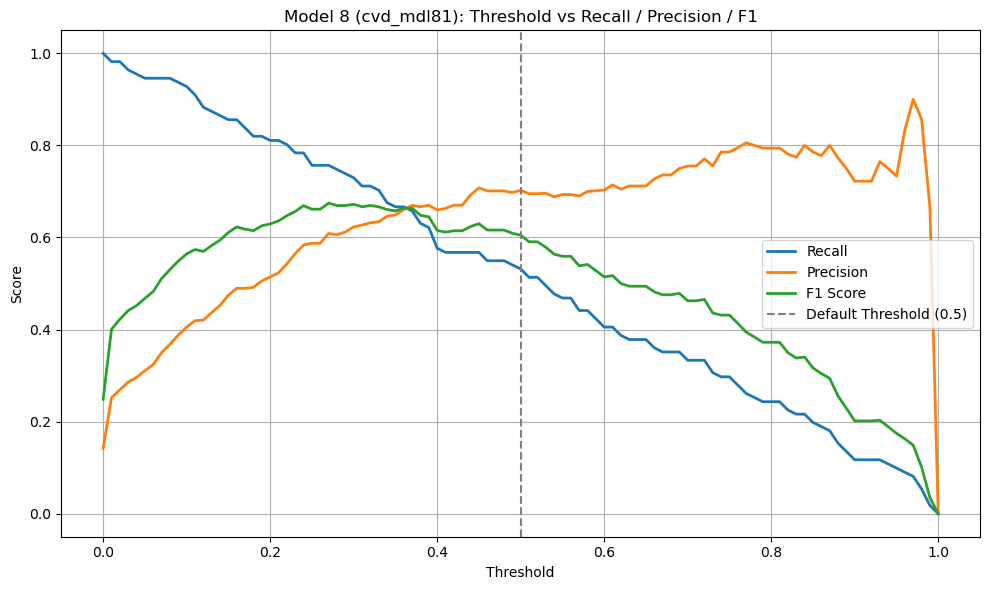


Top 3 thresholds by recall:
  Threshold: 0.00 | Recall: 1.000 | Precision: 0.142
  Threshold: 0.01 | Recall: 0.982 | Precision: 0.252
  Threshold: 0.02 | Recall: 0.982 | Precision: 0.269


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score

# Get true labels and predicted probabilities from Model 8.1
y_true = []
y_scores = []

for Xb, yb in test_ds:
    probs = cvd_mdl81.predict(Xb)      # shape: (batch_size, 2)
    y_scores.extend(probs[:, 1])       # probability of class 1

    if yb.ndim == 2:
        y_true.extend(yb.argmax(axis=1))  # one-hot encoded → class index
    else:
        y_true.extend(yb.astype(int))     # already class labels

    if len(y_true) >= test_ds.samples:
        break

y_true = np.array(y_true)[:test_ds.samples]
y_scores = np.array(y_scores)[:test_ds.samples]

# Threshold sweep
thresholds = np.arange(0.0, 1.01, 0.01)
recalls = []
precisions = []
f1s = []

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    recalls.append(recall_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    f1s.append(f1_score(y_true, y_pred))

# Plot metrics vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, f1s, label='F1 Score', linewidth=2)

plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Model 8 (cvd_mdl81): Threshold vs Recall / Precision / F1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

top_by_recall = sorted(zip(thresholds, recalls, precisions), key=lambda x: x[1], reverse=True)[:3]
print("\nTop 3 thresholds by recall:")
for t, r, p in top_by_recall:
    print(f"  Threshold: {t:.2f} | Recall: {r:.3f} | Precision: {p:.3f}")

##### Choosing the Threshold
In clinical settings, false negatives in cancer detection can be life-threatening. By setting a low threshold (0.02), we capture 98.2% of malignant lesions. Though precision is lower (~27%), this is acceptable for a support tool designed to alert dermatologists early, not replace them.

If we want to prioritise recall, then it might be said to make the threshold 0 (i.e., identifiy 100% of malignant cases), however if we did this, then it would classify every image as malignant, regardless of the model's confidence. This would lead to 100% sensitivity but 0% specificity, overwhelming clinicians with false positives and making the model useless in practice. Instead, we aim for a threshold that balances both true positives and true negatives, often guided by metrics like AUROC (hence we must evaluate the reasonbless of the chosen threshold by the AUROC it achieves also). 

Moving between threshold 0.01 and 0.02 provides no improvement of recall, but some improvement in precision, as so the 0.02 threshold was chosen.
We understand that this threshold is VERY low and WILL classify many lesions as malignant, however given the nature of the task, this is CRUCIAL. It should be considered however that this tool is NOT a diagnostic tool alone, but just ALERTS physicians that instead MORE TESTS ARE NECESSARY, as there is malignancy potential. 

In [36]:
#predictions 
# Set the threshold 
threshold = 0.02  #changed threshold to 0.02

# Binarize & get confusion matrix 
y_pred = (y_scores >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Confusion Matrix:")
print(f"    TN={tn:4d}    FP={fp:4d}")
print(f"    FN={fn:4d}    TP={tp:4d}")

# Compute metrics 
sensitivity = tp / (tp + fn) if tp + fn > 0 else np.nan
specificity = tn / (tn + fp) if tn + fp > 0 else np.nan
precision   = tp / (tp + fp) if tp + fp > 0 else np.nan
npv         = tn / (tn + fn) if tn + fn > 0 else np.nan
accuracy    = accuracy_score(y_true, y_pred)
f1          = f1_score(y_true, y_pred)
auc         = roc_auc_score(y_true, y_scores)

# Print results 
print(f"Threshold = {threshold:.2f}")
print("Confusion Matrix:")
print(f"    TN={tn:4d}    FP={fp:4d}")
print(f"    FN={fn:4d}    TP={tp:4d}\n")
print(f"Sensitivity (Recall):             {sensitivity:.4f}")
print(f"Specificity:                      {specificity:.4f}")
print(f"Precision (PPV):                  {precision:.4f}")
print(f"Negative Predictive Value (NPV):  {npv:.4f}")
print(f"Accuracy:                         {accuracy:.4f}")
print(f"F1 Score:                         {f1:.4f}")
print(f"ROC AUC Score (using all scores): {auc:.4f}")

Confusion Matrix:
    TN= 375    FP= 296
    FN=   2    TP= 109
Threshold = 0.02
Confusion Matrix:
    TN= 375    FP= 296
    FN=   2    TP= 109

Sensitivity (Recall):             0.9820
Specificity:                      0.5589
Precision (PPV):                  0.2691
Negative Predictive Value (NPV):  0.9947
Accuracy:                         0.6189
F1 Score:                         0.4225
ROC AUC Score (using all scores): 0.9224


##### Interpretation
###### Sensitivity (Recall)
* VERY GOOD. The model detects 98 % of true cancers (only 2 are missed (1-0.982 * 111 (no. of malignant cases)). As a triage support tool this is critical because the cost of a miss is extremely high.
###### Specificity
* Only 56 % of benign lesions are correctly ruled out; 44 % trigger a false alarm. That is the sacrifice we are making for very high recall.
###### Precision
* When the model says “malignant”, it is correct only 27 % of the time. Clinicians will need to review most flagged cases, however this is ok, as this model is only to be used as an alert tool.    
###### Negative Predictive Value
* VERY GOOD. A benign prediction is trustworthy (99.5 % chance the lesion is indeed benign). This supports safely excluding these cases from further work‑up.  
###### Accuracy
* Overall accuracy is modest; 62 % of all predictions are correct. Because the dataset is imbalanced however, the accuracy metric is less informative than AUROC or recall.  
###### F1 Score
* Combines precision and recall for the malignant class; the low value reflects the large number of false positives despite near‑perfect recall, but we are willing to make this trade-off.  
###### ROC AUC
*  VERY GOOD. This indicates strong overall model performance across all thresholds. AUC values above 0.9 suggest excellent discrimination between benign and malignant cases.


##### Practical Implications
###### Clinical Safety:
* Missing only 2 cancers out of 111 satisfies a common safety target for screening aids.
* Very high NPV (0.995) means a negative result could allow clinicians to de‑prioritise low‑risk lesions confidently.

###### Operational Burden:
* 296 false positives (≈44 % of all benign cases) create significant additional review workload.
* Workflows must ensure that rapid expert review of flagged images is feasible, or else the system could overwhelm staff.

###### Cost‑Aware Evaluation:
* Having so many patients require further testing (like biopsys, follow-up visits etc.) may increase costs for the hospital/clinic, especially when majority of these cases aren't actually malignant. Hence, we may need to consider adjusting the threshold and sacrificing a bit of recall to acheive a  economically optimal operating point.

###### Reporting to Stakeholders:
* Emphasise that the current cut‑off is deliberately conservative to prioritise patient safety.
* Emphasise that this is NOT a diagnostic tool (not all patients flagged as malignant will actually have cancer), but an alert tool. 

#### Baseline/Naive Model

In [39]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

# Get class distribution from the true test labels 
benign_rate = np.mean(y_true == 0)
malignant_rate = 1 - benign_rate

print(f"Class distribution in test set:")
print(f"  Benign = {benign_rate:.2f}")
print(f"  Malignant = {malignant_rate:.2f}")

# Generate random predictions based on class distribution 
np.random.seed(42)  # For reproducibility
y_pred_baseline = np.random.choice([0, 1], size=len(y_true), p=[benign_rate, malignant_rate])

# Optional: fake "probability" scores based on class distribution (for AUC)
y_scores_baseline = np.full_like(y_true, malignant_rate, dtype=float)

# Compute confusion matrix and metrics 
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_baseline).ravel()

sensitivity = tp / (tp + fn) if tp + fn > 0 else np.nan  # Recall
specificity = tn / (tn + fp) if tn + fp > 0 else np.nan
precision   = tp / (tp + fp) if tp + fp > 0 else np.nan
npv         = tn / (tn + fn) if tn + fn > 0 else np.nan
accuracy    = accuracy_score(y_true, y_pred_baseline)
f1          = f1_score(y_true, y_pred_baseline)
auc         = roc_auc_score(y_true, y_scores_baseline)

# Print results 
print("Stratified Probability Baseline")
print("Confusion Matrix:")
print(f"    TN={tn:4d}    FP={fp:4d}")
print(f"    FN={fn:4d}    TP={tp:4d}\n")
print(f"Sensitivity (Recall):             {sensitivity:.4f}")
print(f"Specificity:                      {specificity:.4f}")
print(f"Precision (PPV):                  {precision:.4f}")
print(f"Negative Predictive Value (NPV):  {npv:.4f}")
print(f"Accuracy:                         {accuracy:.4f}")
print(f"F1 Score:                         {f1:.4f}")
print(f"ROC AUC Score (using all scores): {auc:.4f}")


Class distribution in test set:
  Benign = 0.86
  Malignant = 0.14
Stratified Probability Baseline
Confusion Matrix:
    TN= 573    FP=  98
    FN=  92    TP=  19

Sensitivity (Recall):             0.1712
Specificity:                      0.8539
Precision (PPV):                  0.1624
Negative Predictive Value (NPV):  0.8617
Accuracy:                         0.7570
F1 Score:                         0.1667
ROC AUC Score (using all scores): 0.5000


##### Interpretations
###### Sensitivity (Recall)
* POOR. Finds only ≈17 % of true malignancies, which is dangerously low. 
###### Specificity
* Correctly rejects ≈85 % of benign lesions. This is better than our model, but it is due to the tradeoff we made for higher recall.
###### Precision
* Of all “malignant” predictions, only 16 % are actually malignant, so many false alarms. This means the proportion of unnecessary futher treatments or appointments is even greater than with our model.   
###### Negative Predictive Value
* VERY GOOD. A benign prediction is trustworthy (99.5 % chance the lesion is indeed benign). This supports safely excluding these cases from further work‑up.  
###### Accuracy
* Looks deceptively high, however it is driven mostly by the benign majority. This metric is not informative under the class imbalance.
###### F1 Score
* POOR. Very low harmonic mean of precision and recall confirms the poor malignant detection.
###### ROC AUC
*  POOR. No better than random guessing across thresholds. 


  #### Comparison Between Naive Model and Our Model (8.1)
###### Sensitivity (Recall)
* Dramatic leap: went from missing 83 % of cancers to missing just 2 %. This is the single most important improvement for the purpose of this model.
###### Specificity
* To improve recall, the model trades off specificity, wrongly flagging 44 % of benign lesions. This is clinically acceptable only if physicians can handle the extra reviews that will be needed.
###### Precision
* Still low but nearly doubled. Each “malignant” alert is correct ~27 % of the time vs 16 % before.
###### Negative Predictive Value
* Huge gain: a “benign” result is now trustworthy 99.5 % of the time, which is key for safely ruling out cases and not letting a patient walk away when ey **infact** do have cancer.  
###### Accuracy
* Slight fall in accuracy, but this metric is not particularly informative.
###### F1 Score
* The harmonic balance of precision and recall is more than doubled, confirming the net benefit of Model 8.1 despite the increased false positives.
###### ROC AUC
*  Significant improvement, reflecting the shift from random guessing to excellent discrimination hresholdsresholds.
e
                                                                           
#### Takeaways
###### Life-saving Recall
* The leap to 98 % sensitivity means Model 8.1 now meets (or exceeds) typical clinical triage thresholds. It misses ~2 cancers per 100, versus ~83 with the baseline, a transformational safety improvement.

###### More Review Workload
* Specificity drops by ~30% as the cost of the higher recall, meaning nearly half of benign lesions trigger an alert. Whether this is acceptable depends on clinician capacity and costs.

###### Precision still modest but significantly better
* Although 27 % PPV means most alerts are false positives, doubling PPV halves unnecessary biopsies compared with baseline. .

###### NPV now almost perfect
* At 99.5 %, clinicians can confidently de-escalate benign-classified cases, allowing confidence to be had that a patient leaving after being classified as begign is not actaully a crucial missed cancer case. 

###### AUC shows robust rank ordering
* A model that hasn’t learned anything would score about 0.50 AUROC, meaning it’s no better than random guessing, which is the case for the naive model. Our model’s result, with 0.922 AUROC, shows that it ranks the malignant case higher 92 % of the time. That big gap (> 40 percentage-points) shows it has discovered reliable visual or contextual patterns that separate cancers from benign lesions far beyond chance. This supports the strong architecture and performance of our model.       |
      |


## Visualisations

Visualisations are any techniques that turn the numbers inside a convolutional neural network into pictures a human can inspect. They are useful because CNNs work by millions of learned filter weights that are otherwise opaque. Good visualisations help you, in our context, to:
* See where and what the model is looking at, building trust with clinicians.
* Convey results to non-technical stakeholders with intuitive, image-based evidence.
They can also, in other contexts,:
* Spot spurious cues (e.g., a hospital logo or ruler) the network is using, so you can fix the data or architecture.
* Decide whether a newer model is paying attention to more clinically meaningful regions (model comparison).    |



### Grad-CAM

Grad-CAM is one of the methods used to understand how a CNN is making its predictions, by highlighting influential regions of an image. The core algorithm involves:
* Taking derivatives (computing gradients) of the prediction with respect to the output of the final convolutional layer
* Depth-wise averaging all the activation maps in the final convolutional layer, weighted by the average gradient for each layer.
* Treating the final 2D object as a heatmap.

It shows:
* a coarse heat-map over the last convolutional feature map: red = regions that contributed most to the chosen class score, blue = irrelevant.

It is produced by:
* back-propagating the gradient of the class score to the final conv layer, weight its channels by those gradients, then resize to the input image.

It is useful because:
* it localises which parts of the image drove the decision, at a scale similar to the receptive fields of deep features (good for structures like lesions or organs).

In [40]:
cvd_mdl81.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                             

In [66]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import matplotlib as mpl


img_folder = "C:/Users/13973865/OneDrive - Bond University/deep learning/assignment 2/ISIC Data/ISIC Data/"
img_filename = "ISIC_0024307.jpg"  # make sure this is correct!
img_file = os.path.join(img_folder, img_filename) #name of a random image in the folder (ISIC Data)

img_size = (180,180) #Dimensions assumed by the model being used #change to 180
last_conv_layer_name = "conv2d_7" #in model summary (), last conv layer before pooling

In [67]:
def get_img_array(file_loc, size):
    # `img` is a PIL image of size 299x299
    img = load_img(file_loc, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

img_array = get_img_array(img_file, size=img_size) / 255.0

In [68]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [69]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)


    # Display Grad CAM
    plt.matshow(superimposed_img)
    plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 11ms/step
Predicted probability of malignant (class 1): 0.0000


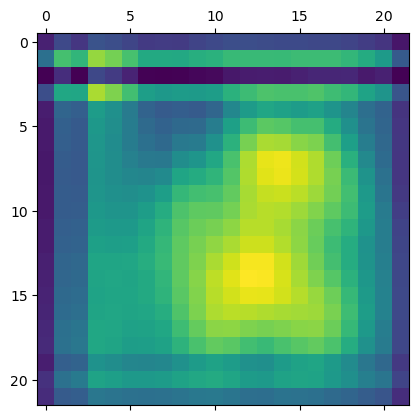

In [70]:
# Prepare image
img_array = preprocess_input(get_img_array(img_file, size=img_size))

# Make model (already defined earlier)
model = cvd_mdl81

# Remove last layer's softmax
#model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(f"Predicted probability of malignant (class 1): {preds[0][1]:.4f}")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

*Predicted Probability*: the network’s output for the “malignant” class was essentially 0 %, i.e. the model is maximally confident this lesion is benign.


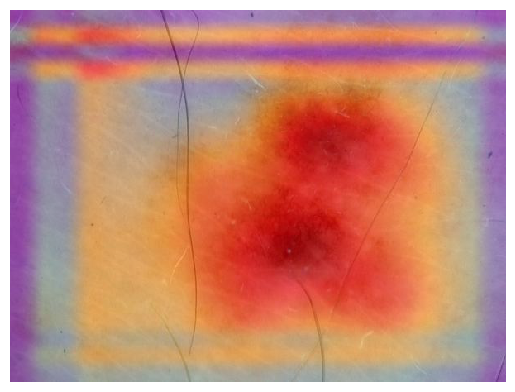

In [71]:
display_gradcam(img_file, heatmap)

This Grad-CAM visualization shows the regions of the image that the convolutional neural network model (cvd_mdl81) focused on when making its classification. The red and orange areas indicate strong activation, meaning the model considered these regions important in determining whether the lesion is malignant or benign. In this example, the model's attention is concentrated directly on the central lesion, suggesting that it learned to detect relevant features such as shape, texture, or color patterns associated with malignancy. Cooler colors (purple, blue) indicate areas with little influence on the decision, such as background skin or borders. This interpretability tool provides reassurance that the model is focusing on clinically relevant areas rather than irrelevant artifacts.

### Saliency Map

In [72]:
#Acknowledgement: this function is modified from an answer to the below question
#https://stackoverflow.com/questions/63107141/how-to-compute-saliency-map-using-keras-backend

def get_saliency_map(model, image, class_idx = None):
    image = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image, training=False)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])    
        loss = predictions[:, class_idx]
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    # take maximum (absolute) across channels
    gradient = tf.math.abs(gradient)
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convert to numpy
    gradient = gradient.numpy()
    
    # normalize between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())

    return smap

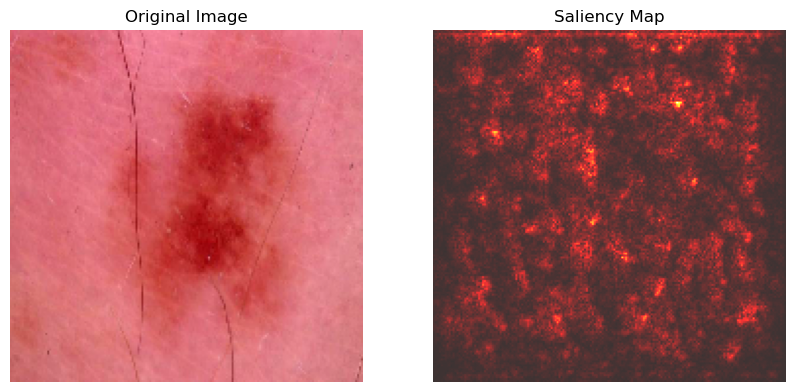

In [73]:
smap = get_saliency_map(cvd_mdl81, img_array)
plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(keras.utils.array_to_img(img_array[0]))
plt.axis('off')
plt.title('Original Image')

# Saliency map
plt.subplot(1, 2, 2)
plt.imshow(smap[0], cmap='hot', alpha=0.8)
plt.axis('off')
plt.title('Saliency Map')

plt.show()

* Only faint response on the long hairs crossing the image suggests the model has learned to ignore hair artefacts, a common dermoscopy nuisance.
* No single dominant hotspot (instead, hotspots are scattered) indicates the model weighs a collection of subtle cues (multiple pigment nests, asymmetry pockets) rather than one decisive shape; that is expected in lesion screening where heterogeneity matters.
* overall however, the saliency map is working, but this specific result is noisy and not visually interpretable. Pixel-level gradients are inherently high-frequency.

Looking at the two pics side-by-side, the Grad-CAM heat-map wins. Its chunky, low-resolution blobs light up the exact patch of the lesion the model cares about, so you can spot the hotspot in a split-second. The saliency map, on the other hand, is super high-res and ends up looking like static, tiny specks everywhere make it hard to tell what’s important. Bottom line: the coarse Grad-CAM view gives a clearer, quicker read of the model’s focus than the pixel-perfect (but noisy) saliency map.

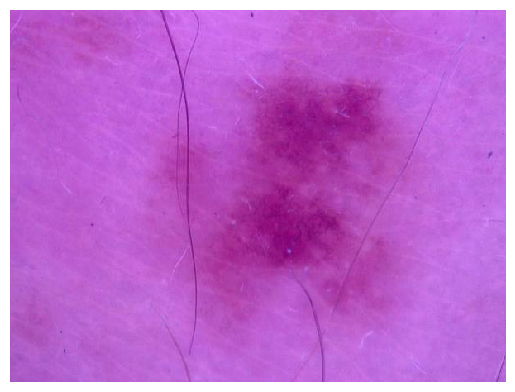

In [74]:
#Our earlier gradcam function is really just a function to superimpose heatmaps on images
#It also works for our saliency map, though the resizing likely hurts the fidelity of the map
display_gradcam(img_file, smap[0])

Looks like the saliency heat-map pretty much vanished once we splashed it onto the photo. All we’re left with is a faint purple tint; no bright “important” spots to guide the eye. That lines up with the warning in the code comment: when you down-size or interpolate a pixel-level saliency map to match the image, most of its fine-grained detail gets smeared out. Bottom line: this overlay isn’t useful the way Grad-CAM is.

## Bibliography
De Luca, G 2024, *How ReLU and Dropout Layers Work in CNNs*, Baeldung, viewed 9 July 2025, <https://www.baeldung.com/cs/ml-relu-dropout-layers>

Stack Overflow 2021, *How to compute saliency map using keras backend*, Stack Overflow, viewed 15 July 2025, <https://stackoverflow.com/questions/63107141/how-to-compute-saliency-map-using-keras-backend>

Shetty, B., Fernandes, R., Rodrigues, A., Chengoden, R., Bhattacharya, S., Lakshmanna, K 2022, *Skin lesion classification of dermoscopic images using machine learning and convolutional neural network*, Scientific Reports, viewed 13 July 2025, <https://www.nature.com/articles/s41598-022-22644-9>